In [1]:
### import libraries ###
import numpy as np
import pandas as pd
import os
import shutil
import subprocess
import seed_select   # from seed_select.py in same folder
import matplotlib.pyplot as plt
import re

In [2]:
### set parameters ###

# [Nsim] is the number of simulations and is used to locate all the related folders
# [Z] is the metallicity of the stars                               e.g. '02' for Z=0.02 solar metallicity
# [SN] is the SN explosion prescription adopted                     e.g. 'del' for delayed or 'com' for compact
# [obs] to select binaries similar to one observed                  e.g. 'cyg_x-3--Zd13' for Zdziarski 2013 ranges

Nsim = '1mln'
Z = '015'
kick_single = 'unified'
kicks = [kick_single]
#kicks = [kick_single,'hobbs265','hobbs51']
SNs = ['rap','del','com']
bintype = 'BHBH_GW_WRBH'
obs = 'cyg_x-3'
version = '3.0.0-Spindevel_RLO'                            # for SEVN2 version adopted

mranges = ['Ko17','An22','Zd13']


commonSNs = ['rap','com']   # only common candidates to consider

In [244]:
### make sure paths exist ###
# path_Zkick = f'./v_{version}/Z{Z}_{kick}'
# os.makedirs(path_Zkick, exist_ok=True)

# Analysis of binaries common in both SN modes for each given kick

In [3]:
# extracts list with names of binaries in each mrange and SN model
for kick in kicks:
    # create folder to store results
    path_kick = f'./v_{version}/Z{Z}_{kick}'
    os.makedirs(path_kick, exist_ok=True)
    
    # prepare to store results for different SN types
    for SN in SNs:
        path_prog = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/dataframes/progenitors/'
        # for a fixed kick and SN model get the names of progenitors of candidates in a given mass range
        for mrange in mranges:
            prog = pd.read_csv(f'{path_prog}p_{bintype}_{obs}--{mrange}.csv')
            names = prog.name.to_list()
            with open(f'{path_kick}/{mrange}_{SN}_{bintype}_{obs}.txt', 'w') as f:
                for item in list(names):
                    f.write("%s\n" % item)

In [4]:
# finds common binaries for a given mrange among the SN models used
for kick in kicks:
    # create folder to store results
    path_kick = f'./v_{version}/Z{Z}_{kick}'
    
    with open(f'{path_kick}/recap_{bintype}_{obs}.txt', 'w') as frec:
        for m,mrange in enumerate(mranges): #for a given mrange get common binaries for two SN types
            names_mrange = []
            for SN in SNs:
                try:
                    names = pd.read_csv(f'{path_kick}/{mrange}_{SN}_{bintype}_{obs}.txt',header=None)
                    names = names[0].to_list()
                    names_str = list(map(str,map(int,names))) # convert into list of strings
                except pd.errors.EmptyDataError:
                    names_str = []
                names_mrange.append(names_str)
                frec.write(f'{mrange} has {len(names_str)} binaries with SN = {SN} \n')
            for j in range(0,len(SNs)):
                for k in range(j+1, len(SNs)):
                    common = set(names_mrange[j]) & set(names_mrange[k])  # compare each SN with the following model
                    # write result
                    with open(f'{path_kick}/common_{mrange}_{SNs[j]}_{SNs[k]}.txt', 'w') as f:
                        for item in list(common):
                            f.write("%s\n" % item)
                    frec.write(f'{len(common)} common binaries for {mrange} obtained both with {SNs[j]} and {SNs[k]} SN mode\n')       
            frec.write('-------------------------------------- \n')    

In [245]:
# #import pandas.io.common
# if common_read == True:
#     common_list_nested = [] # contains the three lists of lists, one for each kick
#     for kick_single in kicks:
#         common_list = []     # contains the three lists for the three mass ranges for a given kick
#         for mrange in mranges:
#             try:
#                 common = pd.read_csv(f'./v_{version}/Z{Z}_{kick_single}/common_{mrange}.txt',header=None)
#                 common = common[0].to_list()
#                 common_str = list(map(str,map(int,common))) # convert into list of strings
#             except pd.errors.EmptyDataError:
#                 common_str = []
#             common_list.append(common_str) 
#         common_list_nested.append(common_list)

# Re-simulate single set with SEVN2 only for a given kick

In [5]:
def SEVN2simulate(version,Nsim,Z,SN,kick_single,df_name):
    # generate initial conditions
    seed_select.Generate(version,Nsim,Z,SN,kick_single,df_name)

    # run the SEVN2 simulation
    # WARNING: check the kick settings match with the desired kick modality
    # do this check MANUALLY (to be implemented a pipeline)
    path_to_run_scripts = f'/home/erika/Scrivania/sevn/SEVN2-{version}/run_scripts'
    if os.path.exists(f'{path_to_run_scripts}sevn_output'):
            shutil.rmtree(f'{path_to_run_scripts}sevn_output',ignore_errors=True)

    p = subprocess.Popen('./run.sh', cwd= path_to_run_scripts, stdout=subprocess.PIPE)
    for line in p.stdout:
        print(line.decode().strip())

    # copy the run_scripts directory with the results
    path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick_single}/{df_name}/'
    shutil.copytree(path_to_run_scripts, f'{path_results}/run_scripts', dirs_exist_ok=True)
    print('#########################################')
    print('#########################################')
    print('#########################################')
    print(f'output copied in {path_results}')
    print('#########################################')
    print('#########################################')
    print('#########################################')

In [6]:
generate = 'general'

if generate == 'candidates':
    for mrange in mranges:
        df_name = f'{bintype}_{obs}--{mrange}'
        for SN in SNs:
            # read list of candidate names for a given SN and mass range
            try:
                path_Zkick = f'./v_{version}/Z{Z}_{kick_single}'
                names = pd.read_csv(f'{path_Zkick}/{mrange}_{SN}_{bintype}_{obs}.txt',header=None)
                names = names[0].to_list()
                names_str = list(map(str,map(int,names))) # convert into list of strings
            except pd.errors.EmptyDataError:
                names_str = []

            # proceed only if at least one candidate is found
            if len(names_str) !=0:
                SEVN2simulate(version,Nsim,Z,SN,kick_single,df_name)
    #             # generate initial conditions with seed
    #             # listBin.dat with all candidates p_{df_name} i.e. ALL observed candidates for selected Z, com, kick
    #             seed_select.Generate(version,Nsim,Z,SN,kick_single,df_name)

    #             # run the SEVN2 simulation
    #             # WARNING: check the kick settings match with the desired kick modality
    #             # do this check MANUALLY (to be implemented a pipeline)
    #             path_to_run_scripts = f'/home/erika/Scrivania/sevn/SEVN2-{version}/run_scripts'
    #             if os.path.exists(f'{path_to_run_scripts}sevn_output'):
    #                     shutil.rmtree(f'{path_to_run_scripts}sevn_output',ignore_errors=True)

    #             p = subprocess.Popen('./run.sh', cwd= path_to_run_scripts, stdout=subprocess.PIPE)
    #             for line in p.stdout:
    #                 print(line.decode().strip())

    #             # copy the run_scripts directory with the results
    #             path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick_single}/{df_name}/'
    #             shutil.copytree(path_to_run_scripts, f'{path_results}/run_scripts', dirs_exist_ok=True)
    #             print('#########################################')
    #             print('#########################################')
    #             print('#########################################')
    #             print(f'output copied in {path_results}')
    #             print('#########################################')
    #             print('#########################################')
    #             print('#########################################')

            else:
                print(f'No candidates for {mrange}')
                
elif generate == 'general':
    for SN in SNs:
        SEVN2simulate(version,Nsim,Z,SN,kick_single,df_name=bintype)

Generating the listBin.dat file with seeds
SEVN is running...
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0006
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/004
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0014
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/00001
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0004
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0002
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/00005
inspectig dir = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001
inspectig dir 

cp: impossibile eseguire stat di '~/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/build/exe/sevnB.x': File o directory non esistente


Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/tconv.dat
Found and ope

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/hsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/rhe.dat
Found and open

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/depthconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/hesup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/hsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/qconv.dat
Found and ope

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parse

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/lumi.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/mass.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/mco.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0

Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/mco.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/mhe.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/phase.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/radius.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/time.dat
Found and opened
read the tables
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/csup.dat
Found and opened
Search optional file tables = /home/e

cp: impossibile eseguire stat di '~/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/build/exe/sevnB.x': File o directory non esistente


Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0002/lumi.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0002/mass.dat


Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/hesup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/hsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/rco.dat
Found and op

Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/mhe.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/phase.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/radius.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/time.dat
Found and opened
read the tables
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/csup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/depthconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindeve

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/hesup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/hsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0004/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec

Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/mco.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/mhe.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/phase.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/radius.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/time.dat
Found and opened
read the tables
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/csup.dat
Found and opened
Search optional file tables = /home/e

cp: impossibile eseguire stat di '~/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/build/exe/sevnB.x': File o directory non esistente


Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0001/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0002/lumi.dat
Found and opened

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0008/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/0014/lumi.dat
Found and opened

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/inertia.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/nsup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/osup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_AGB/003/tconv.dat
Found and opened
Sea

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00002/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00005/lumi.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00005/mass.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00005/mco.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00005/mhe.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/00005/phase.dat
Found and opened
read the tables
Search required file table

Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/phase.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/radius.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/time.dat
Found and opened
read the tables
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/csup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/depthconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/0008/hesup.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sev

Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/qconv.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/rco.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/rhe.dat
Found and opened
Search optional file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/003/tconv.dat
Found and opened
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/005/lumi.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tables/SEVNtracks_parsec_pureHe36/005/mass.dat
Found and opened
read the tables
Search required file tables = /home/erika/Scrivania/sevn/SEVN2-3.0.0-Spindevel_RLO/tab

# Plots

In [7]:
### set parameters for plots ###
plt.rcParams.update({'text.usetex': False, 
                     'font.size': 10})

# Single evo

rap


/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


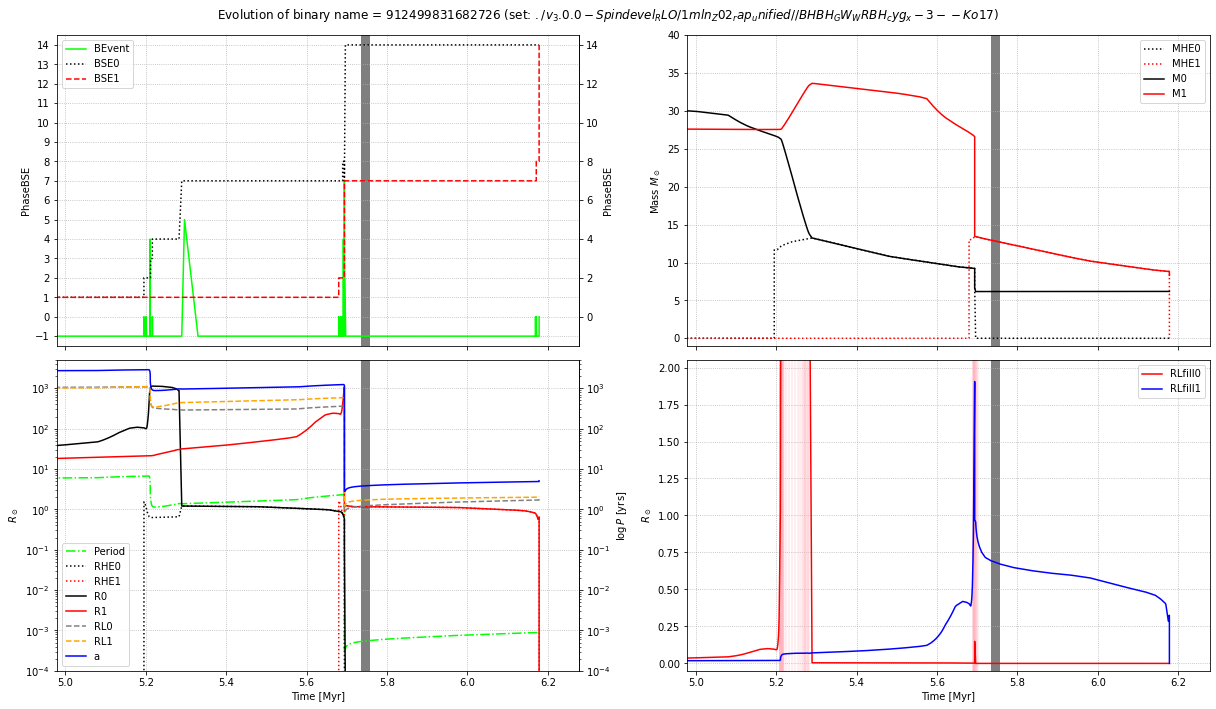

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


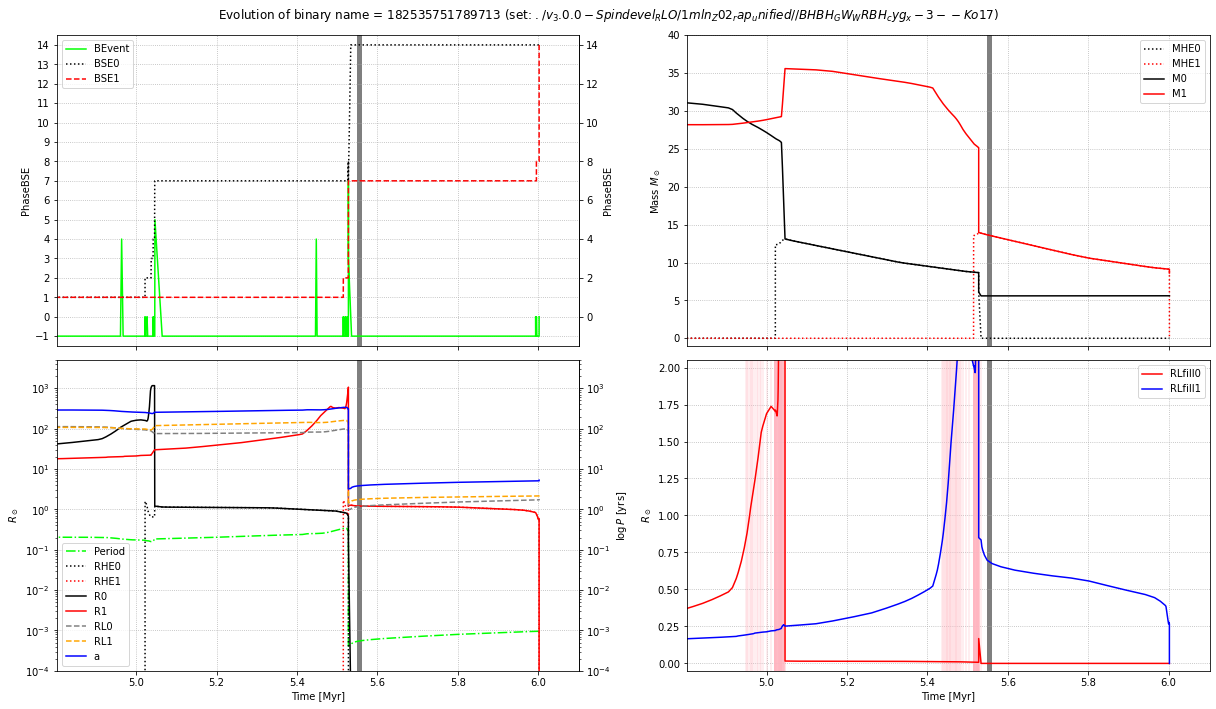

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


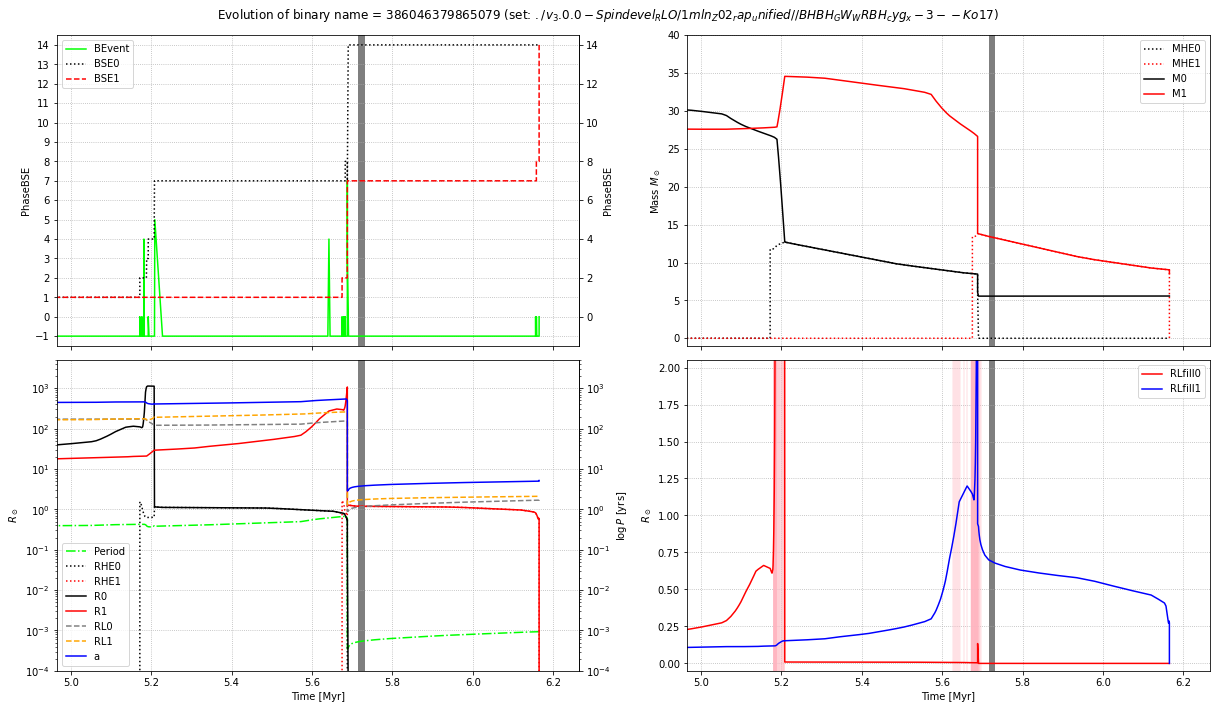

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


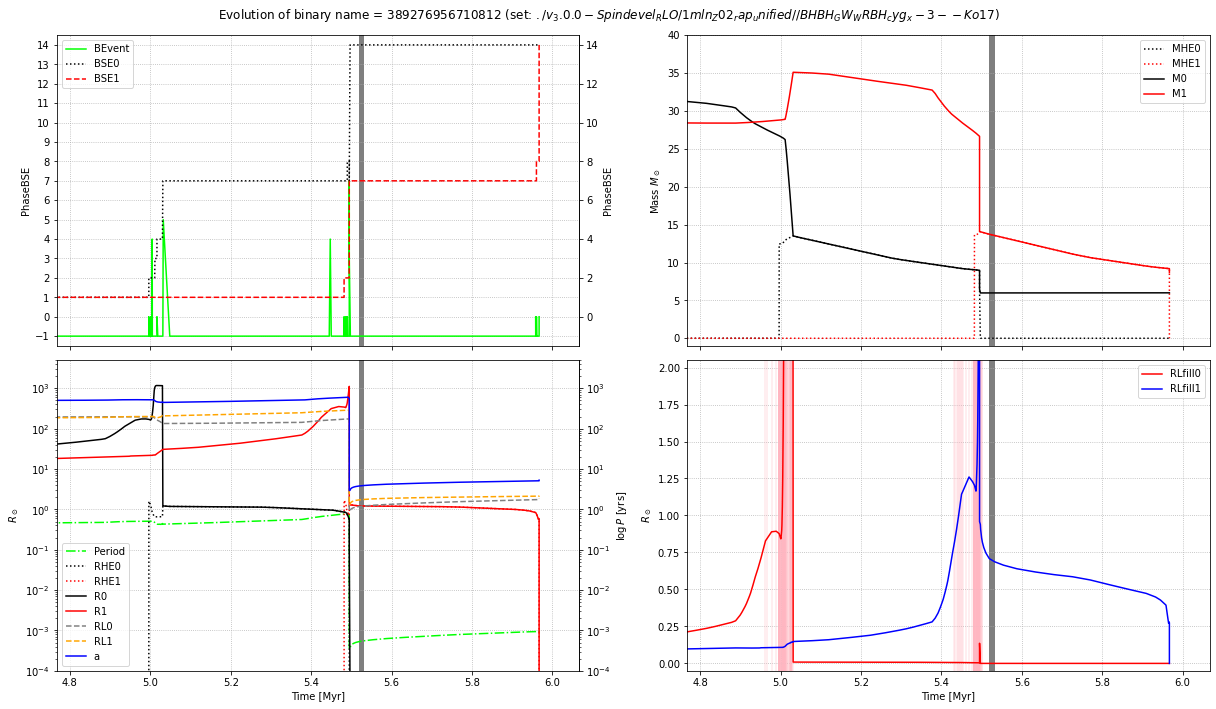

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


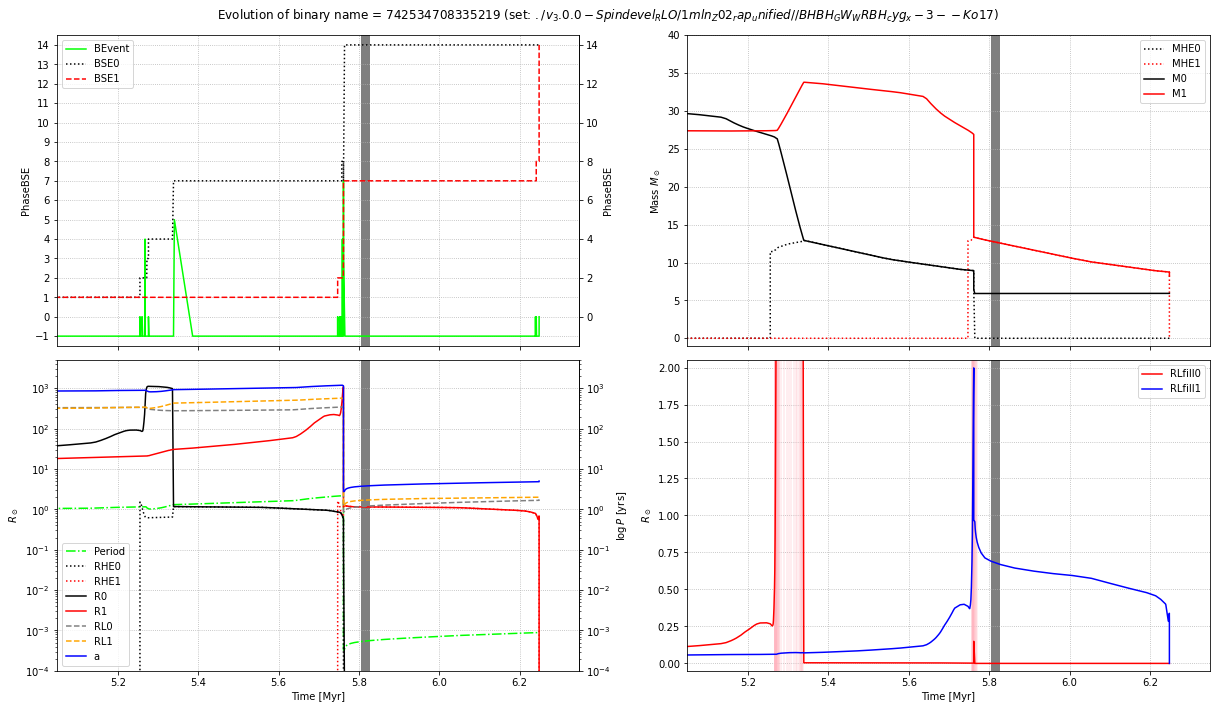

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


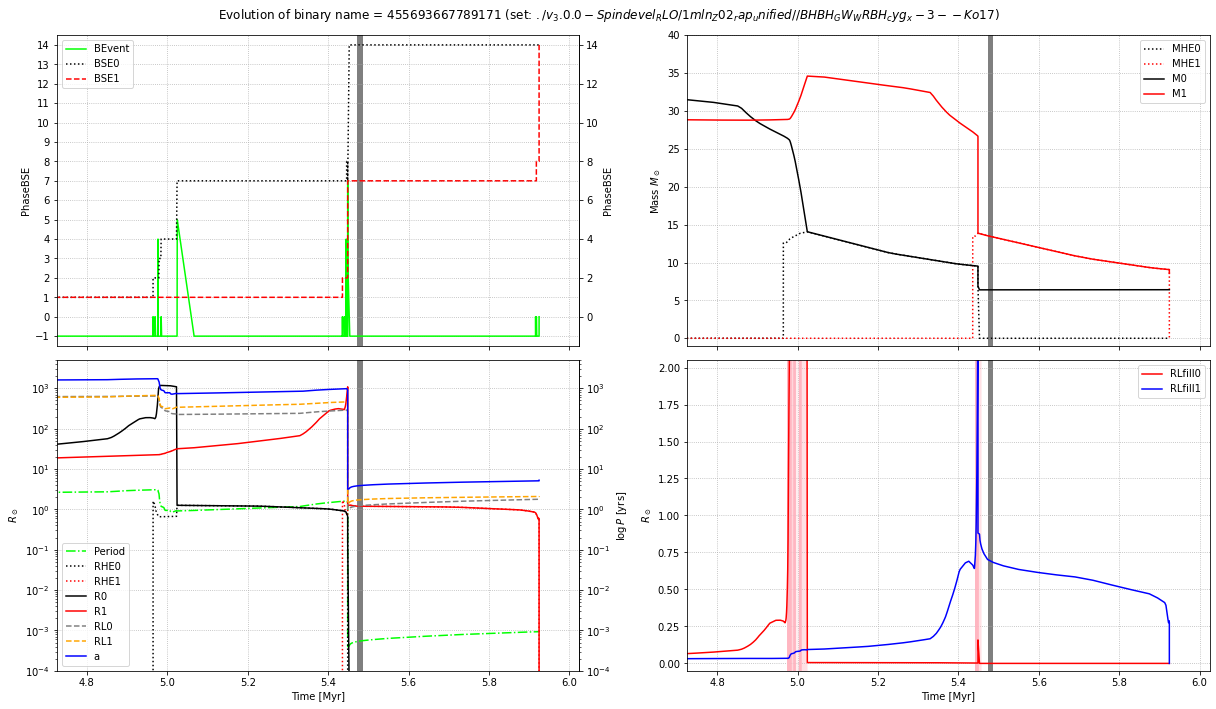

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


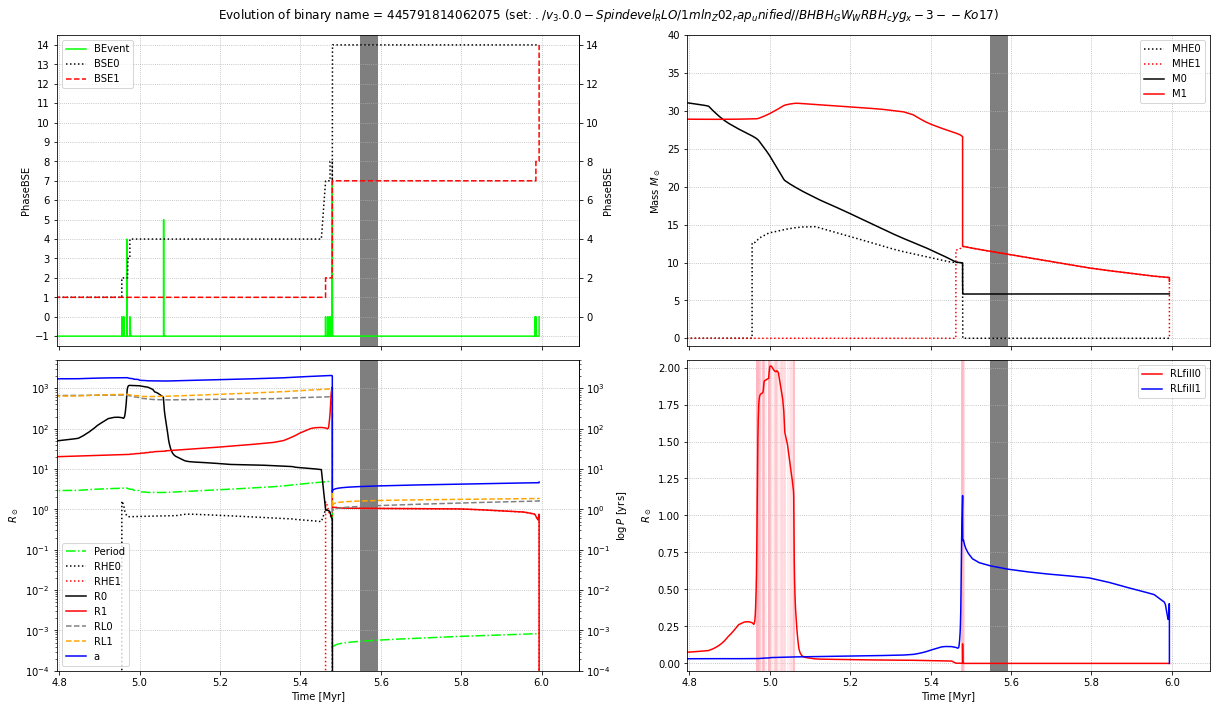

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


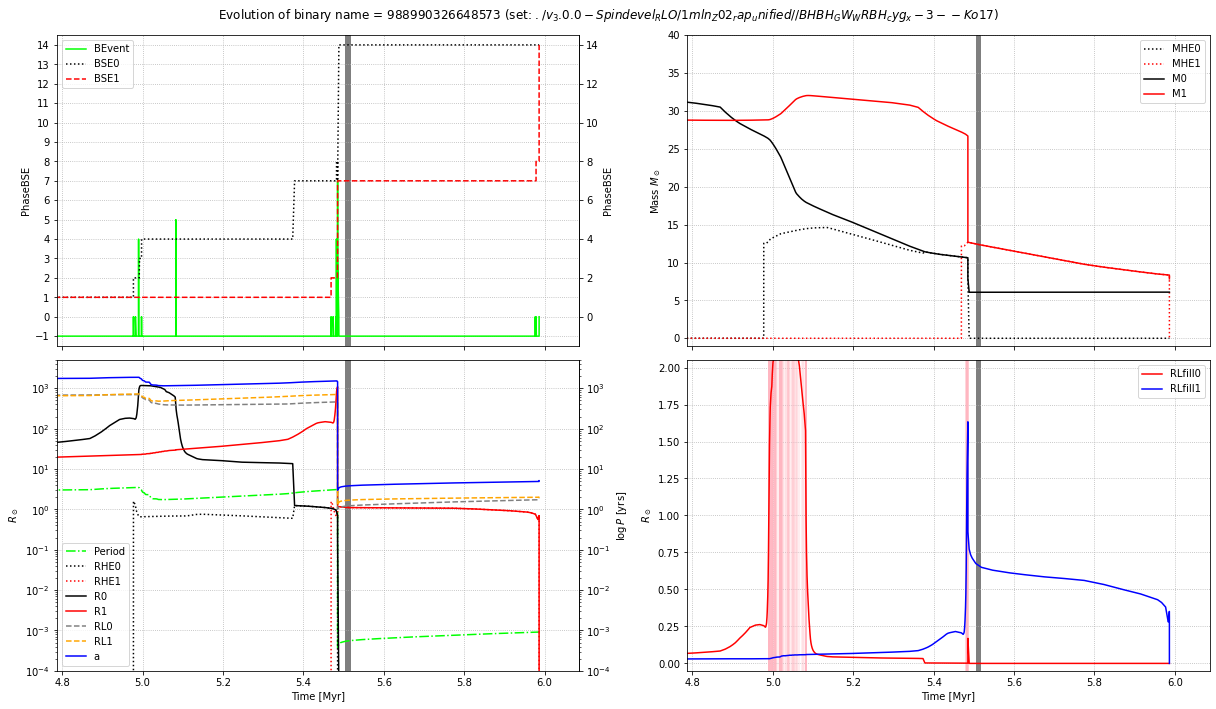

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


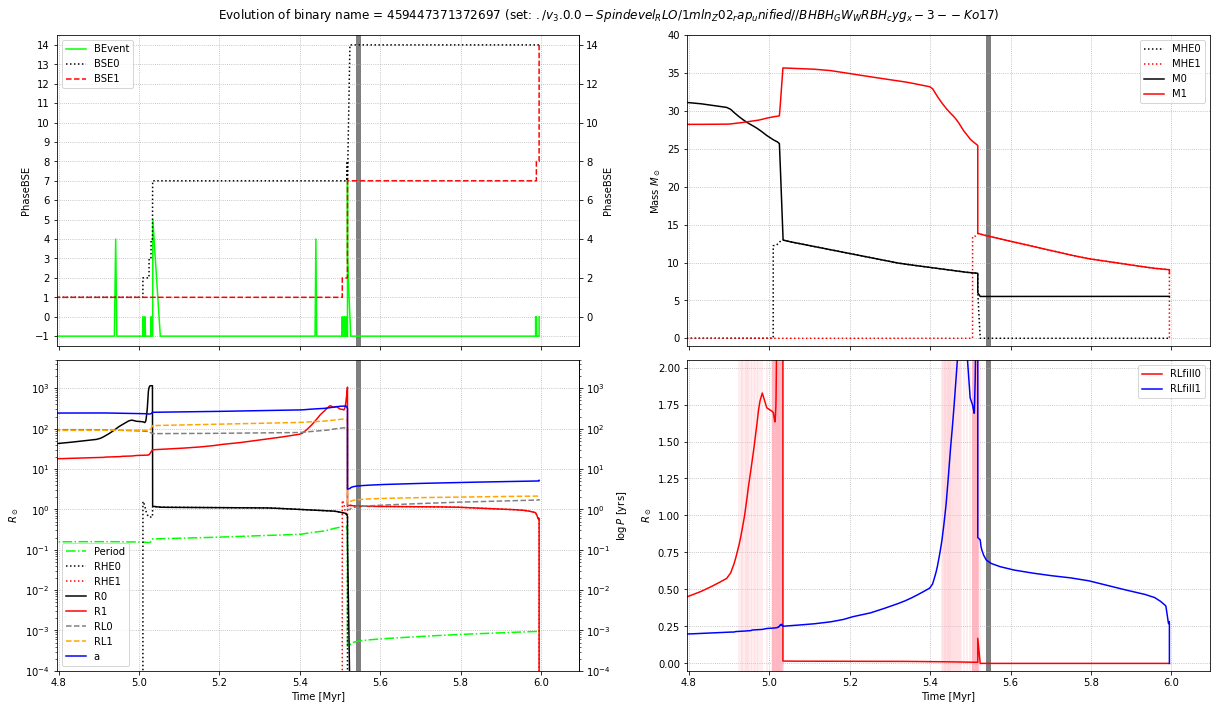

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


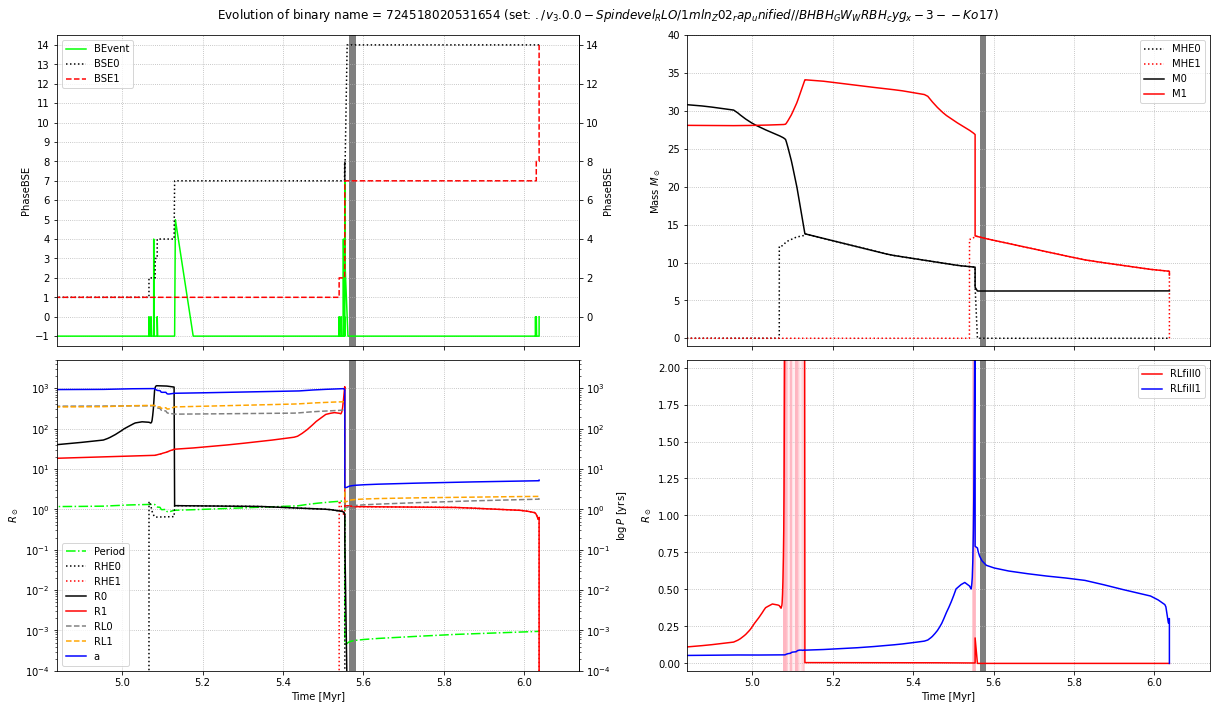

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


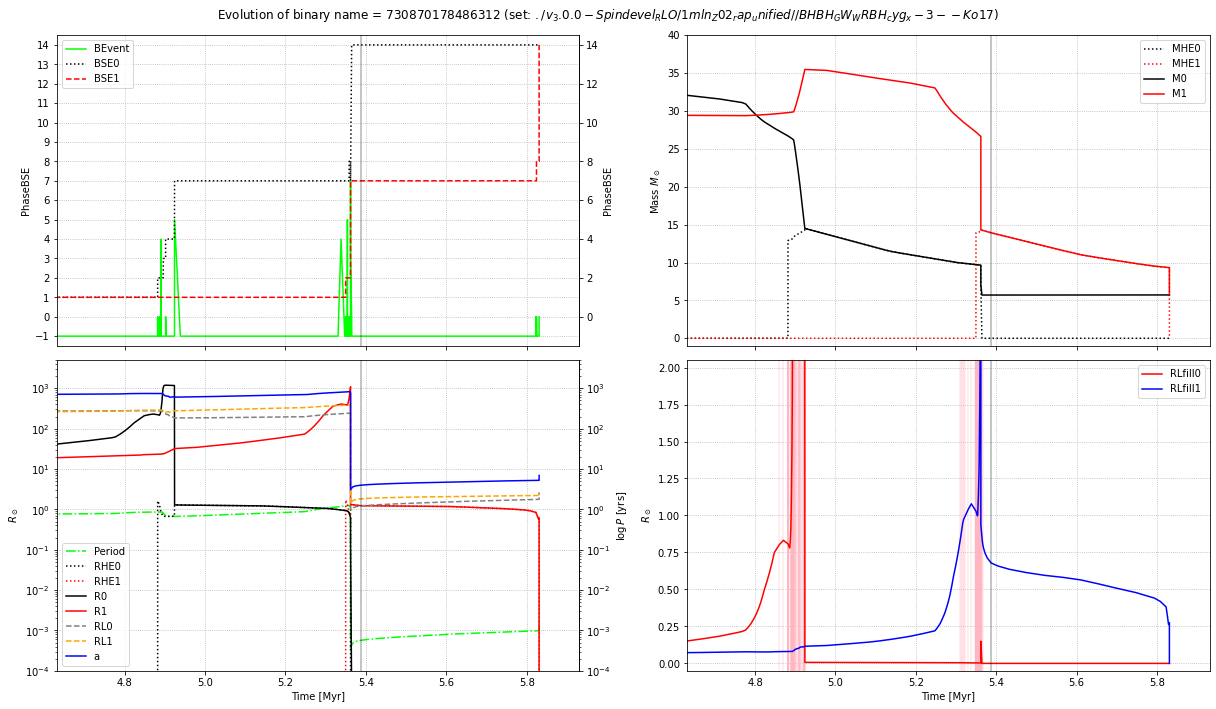

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


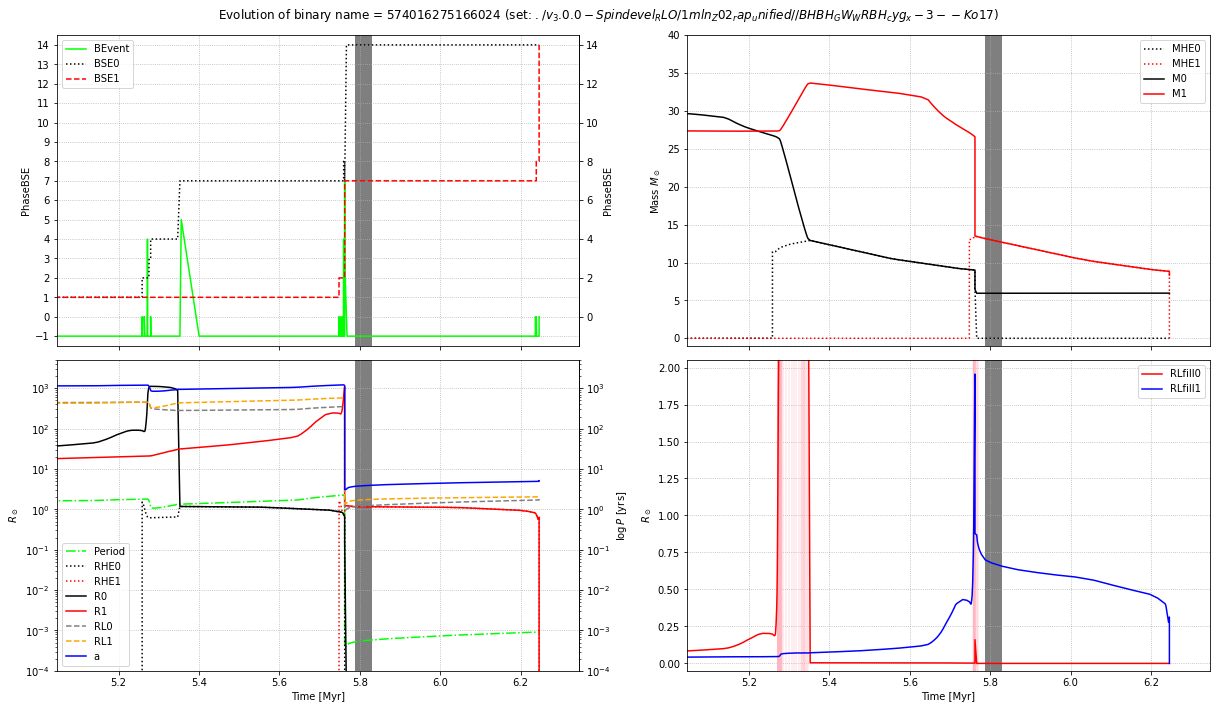

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


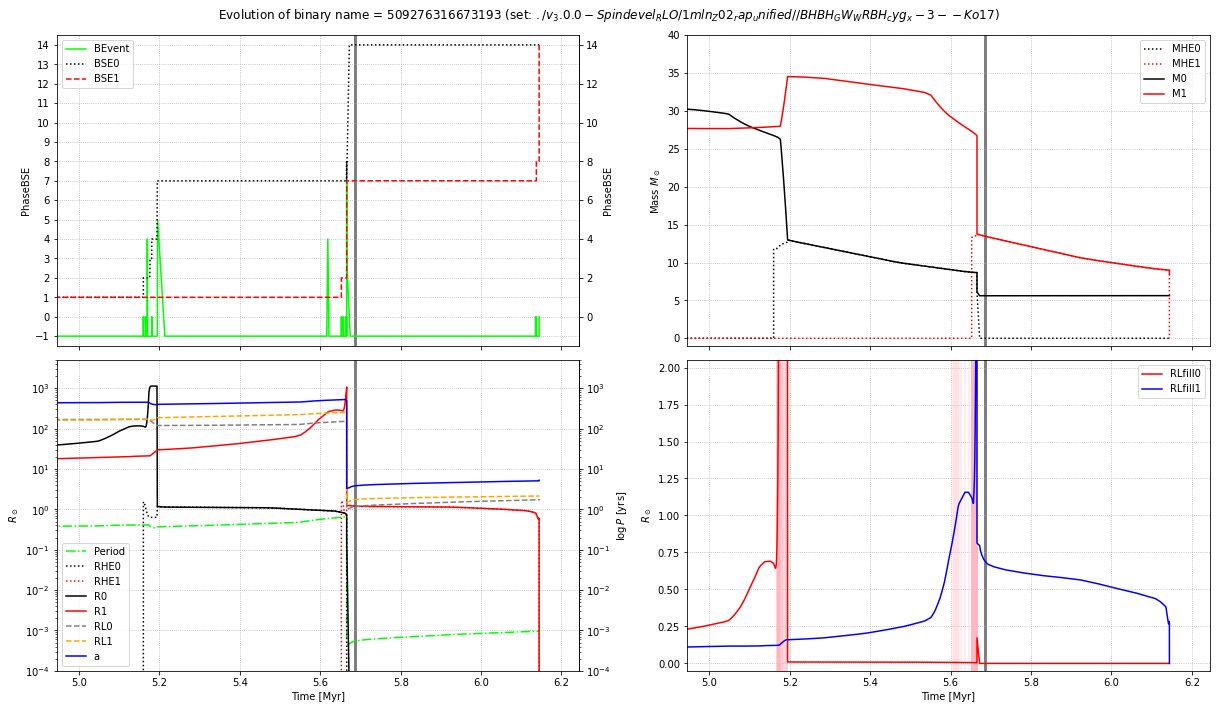

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


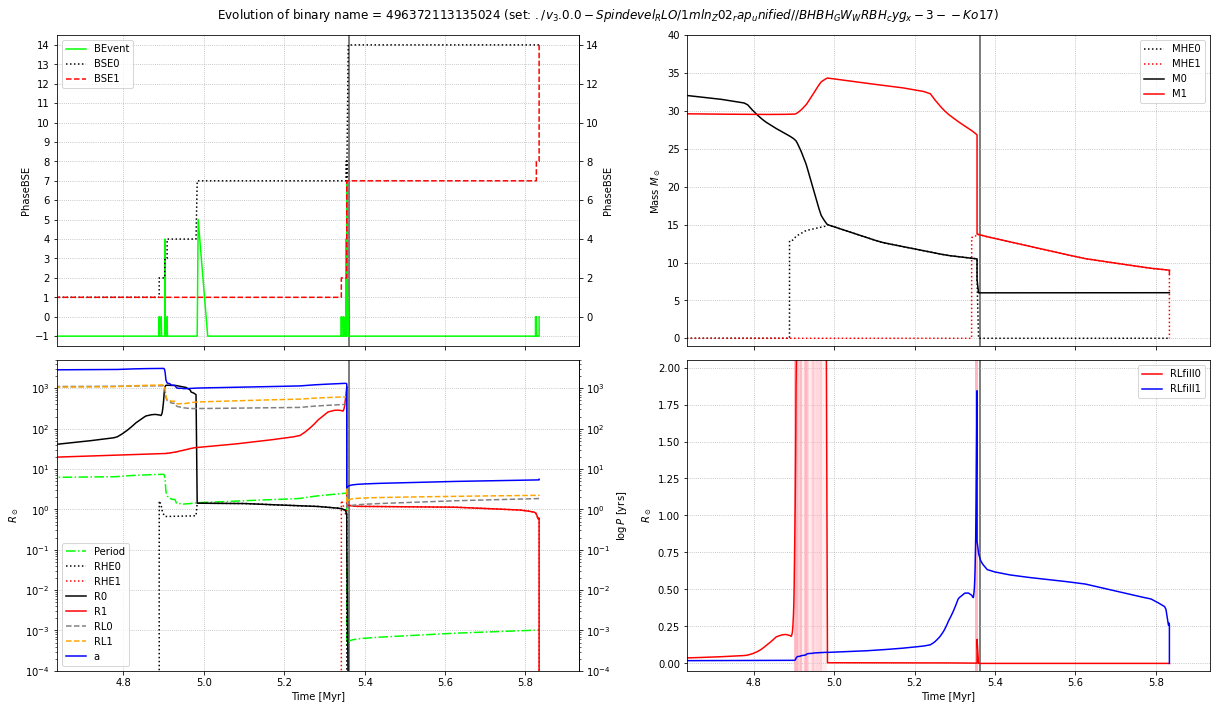

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


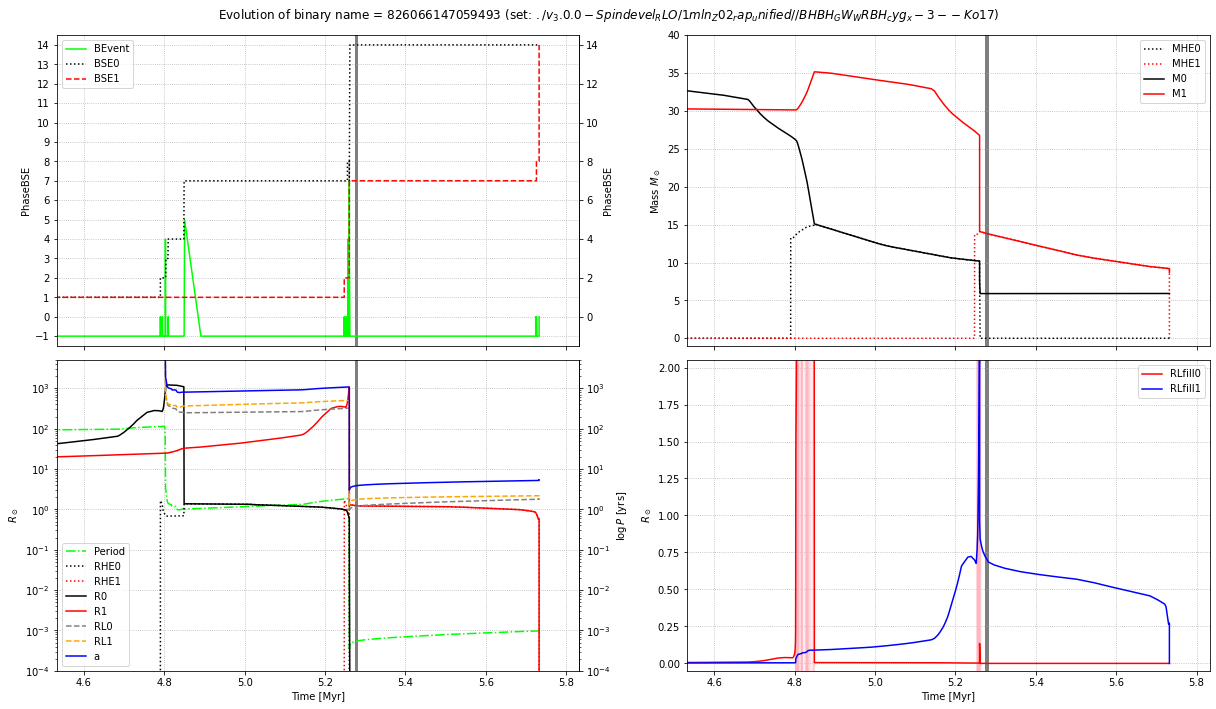

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


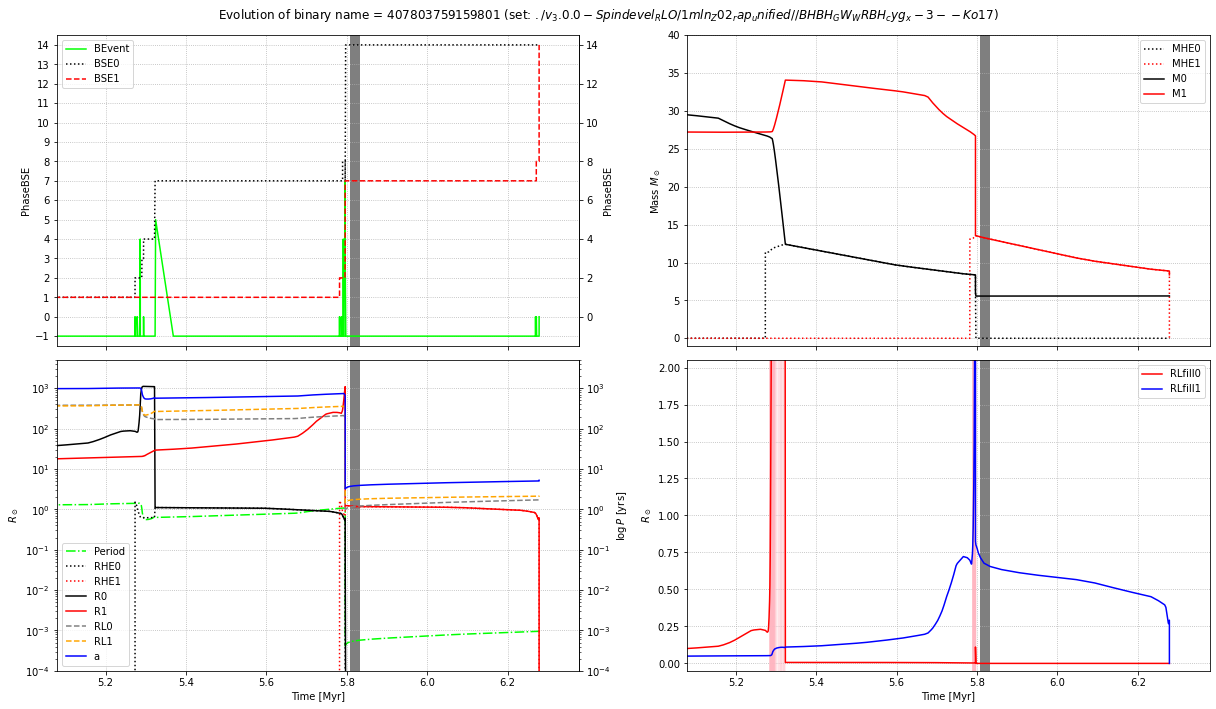

com


/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


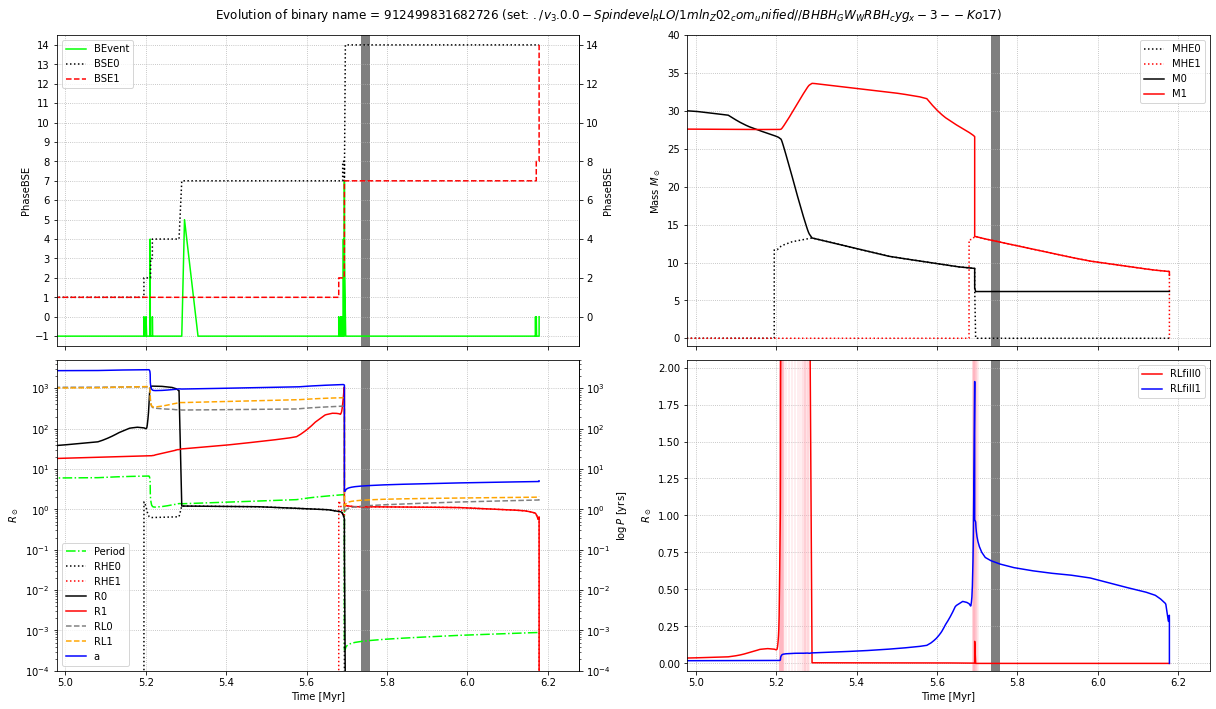

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


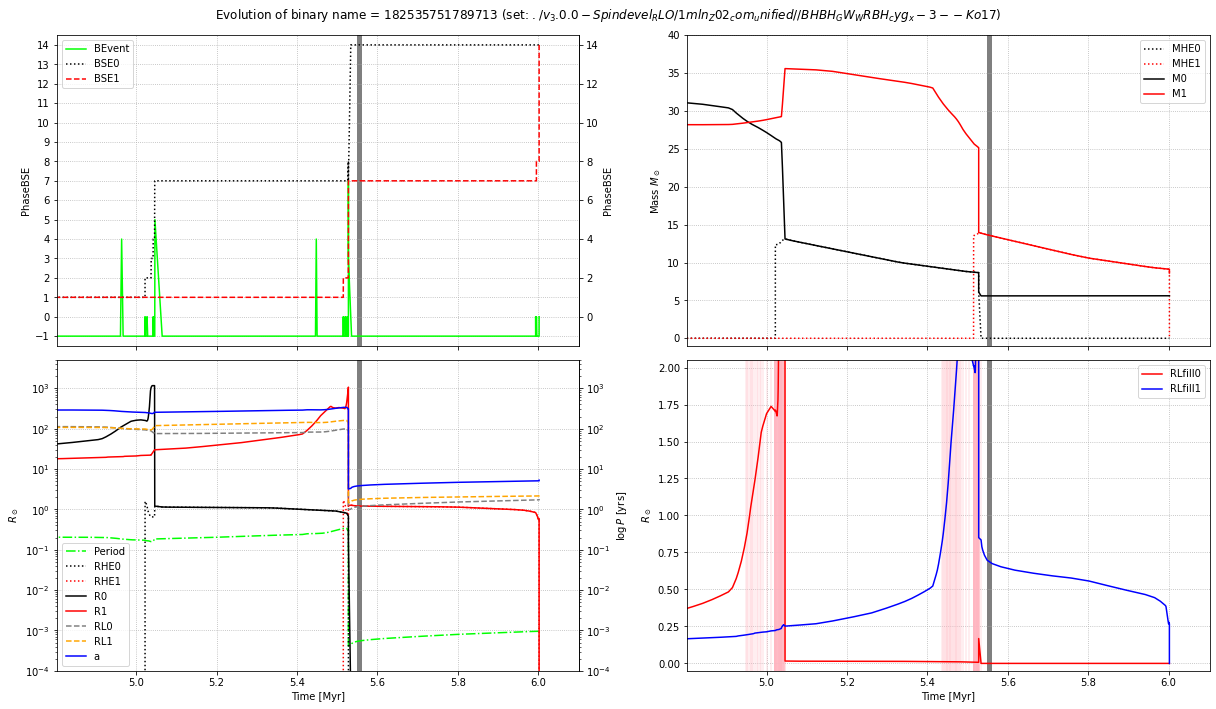

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


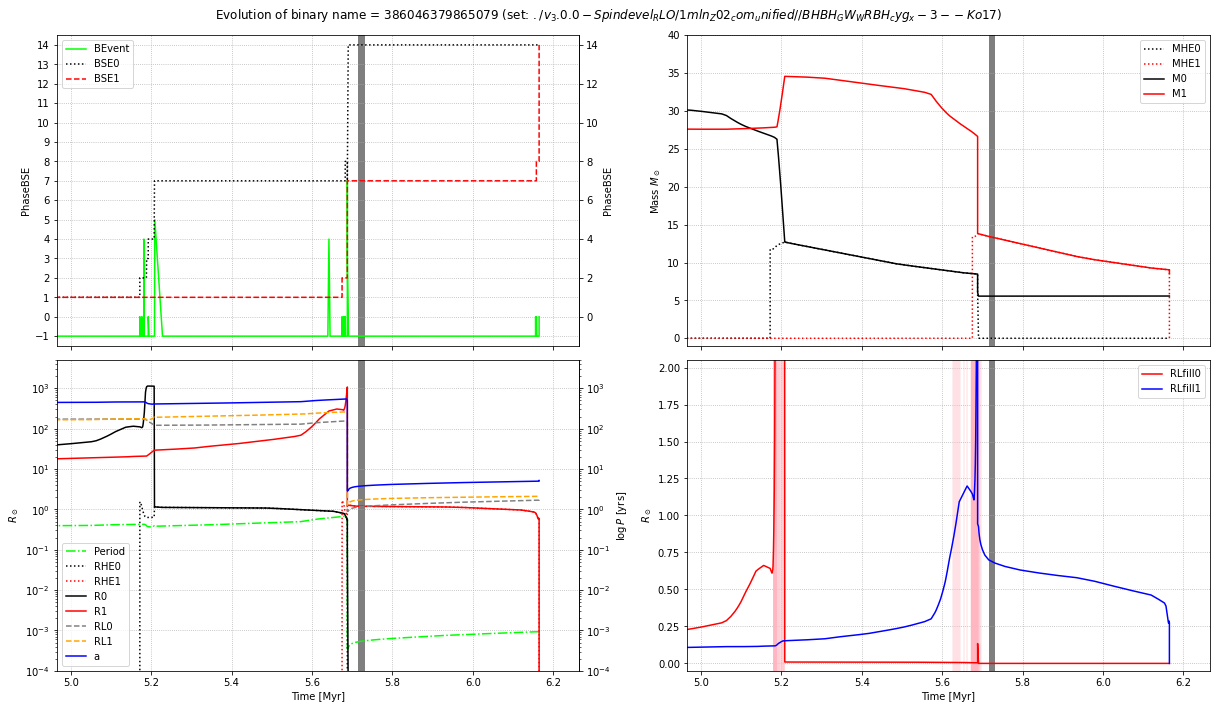

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


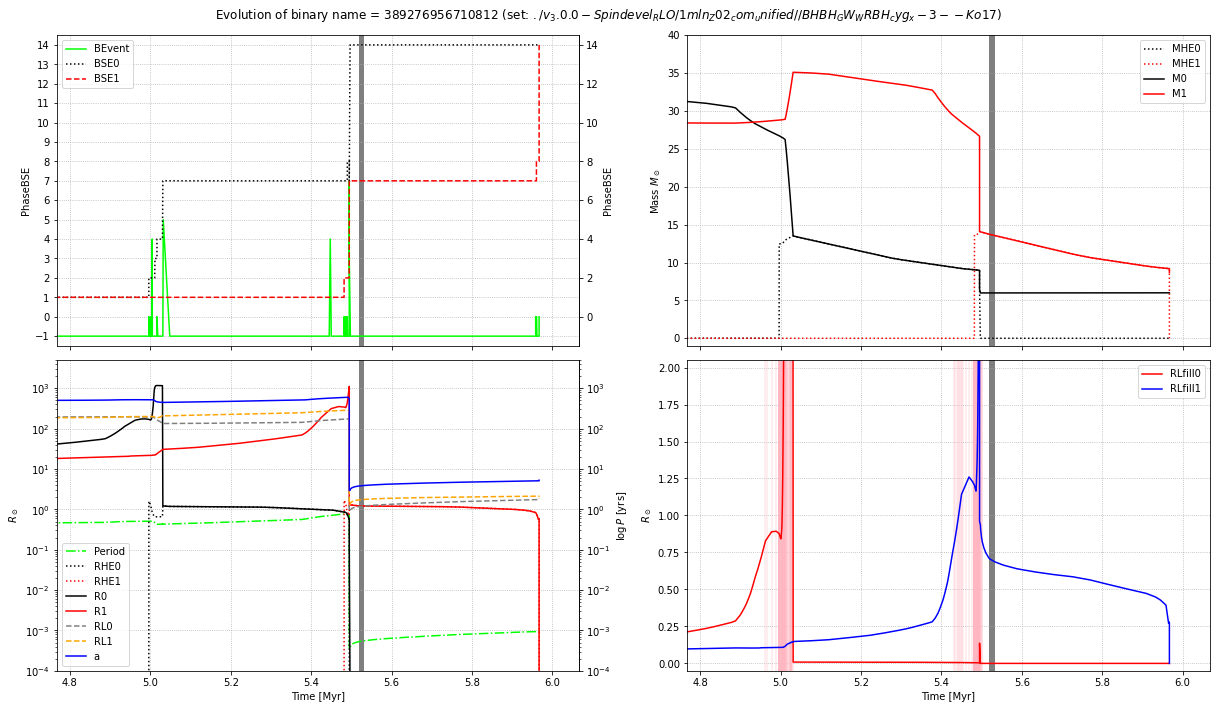

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


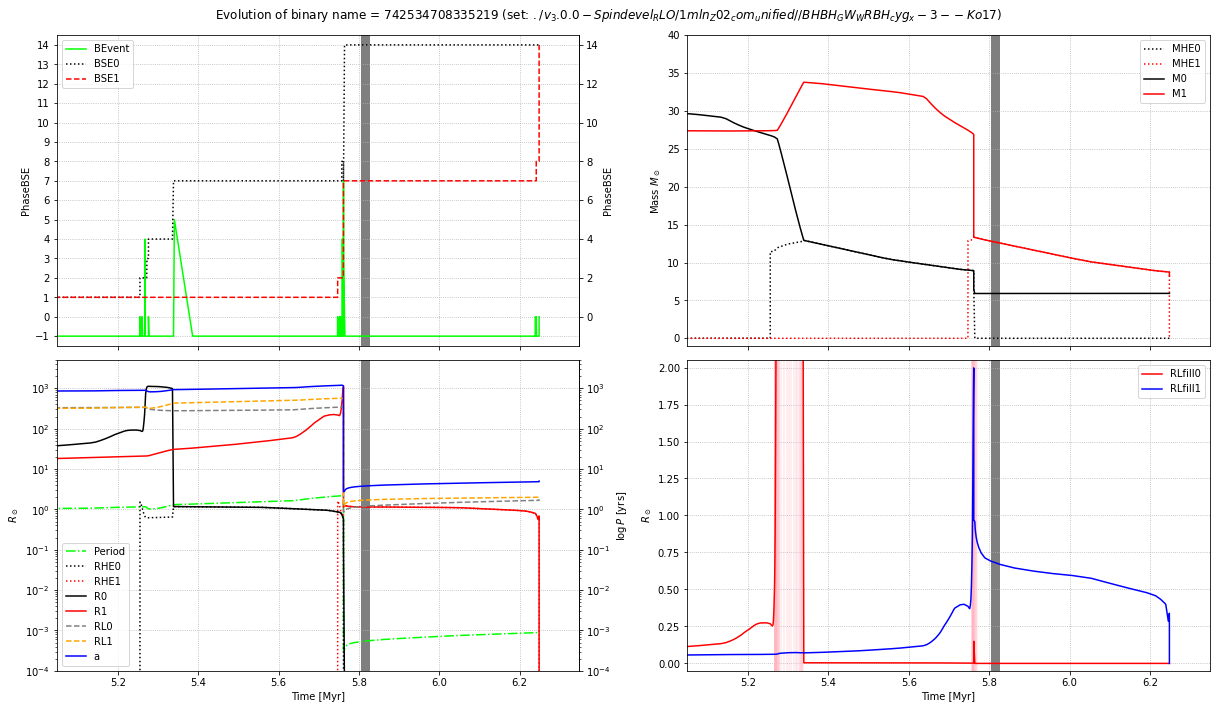

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


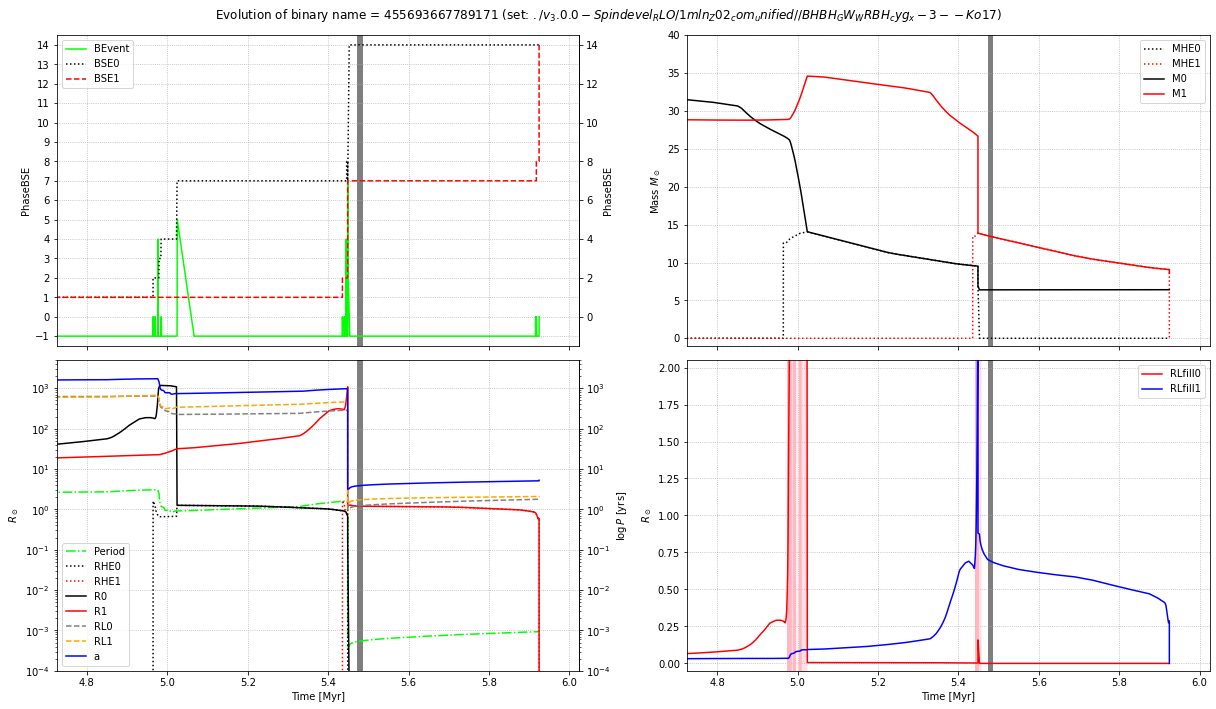

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


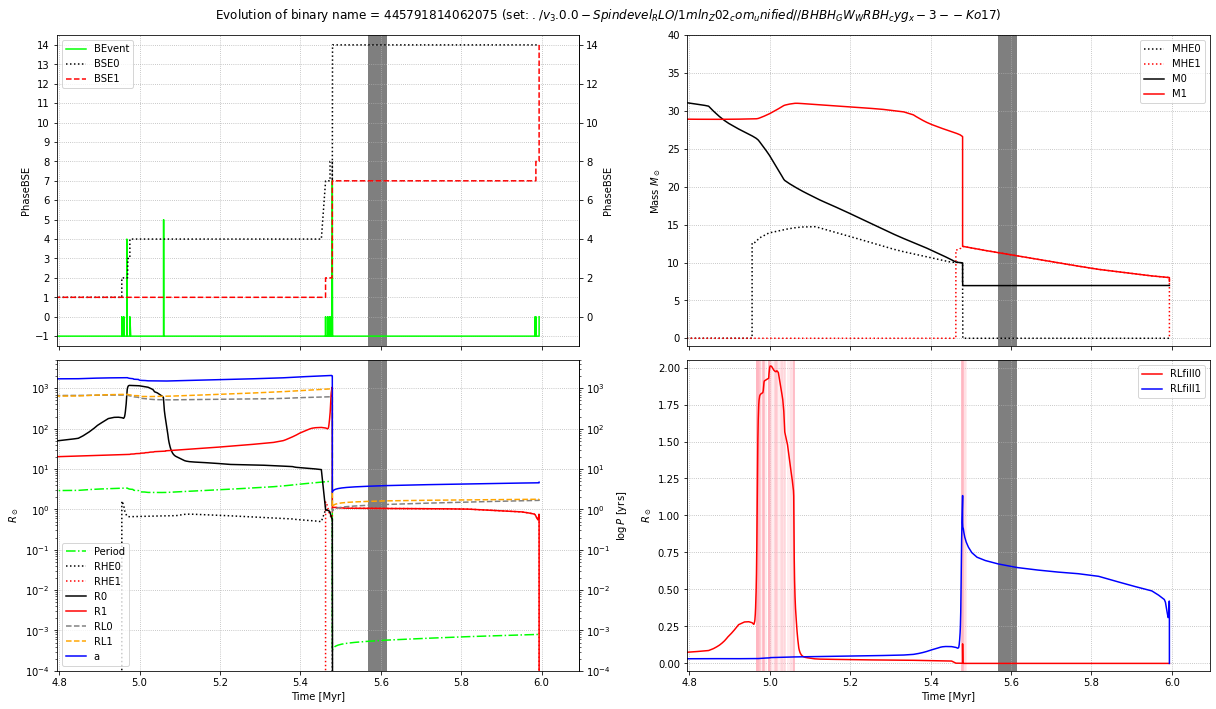

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


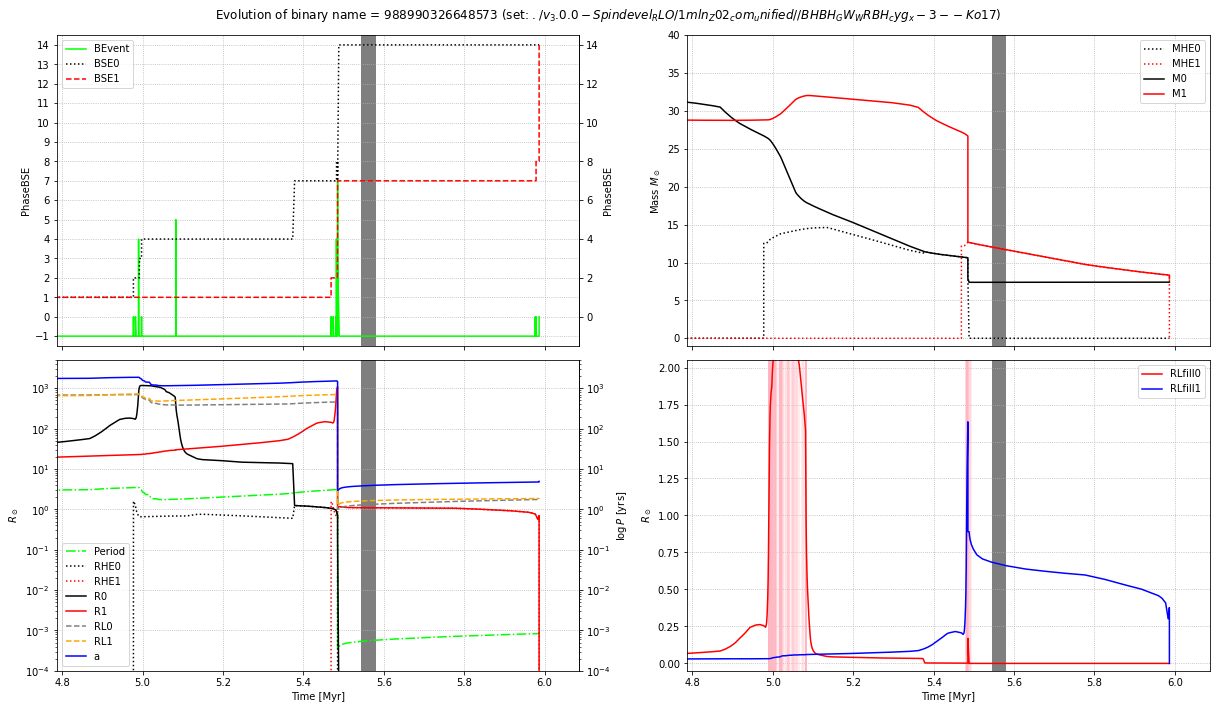

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


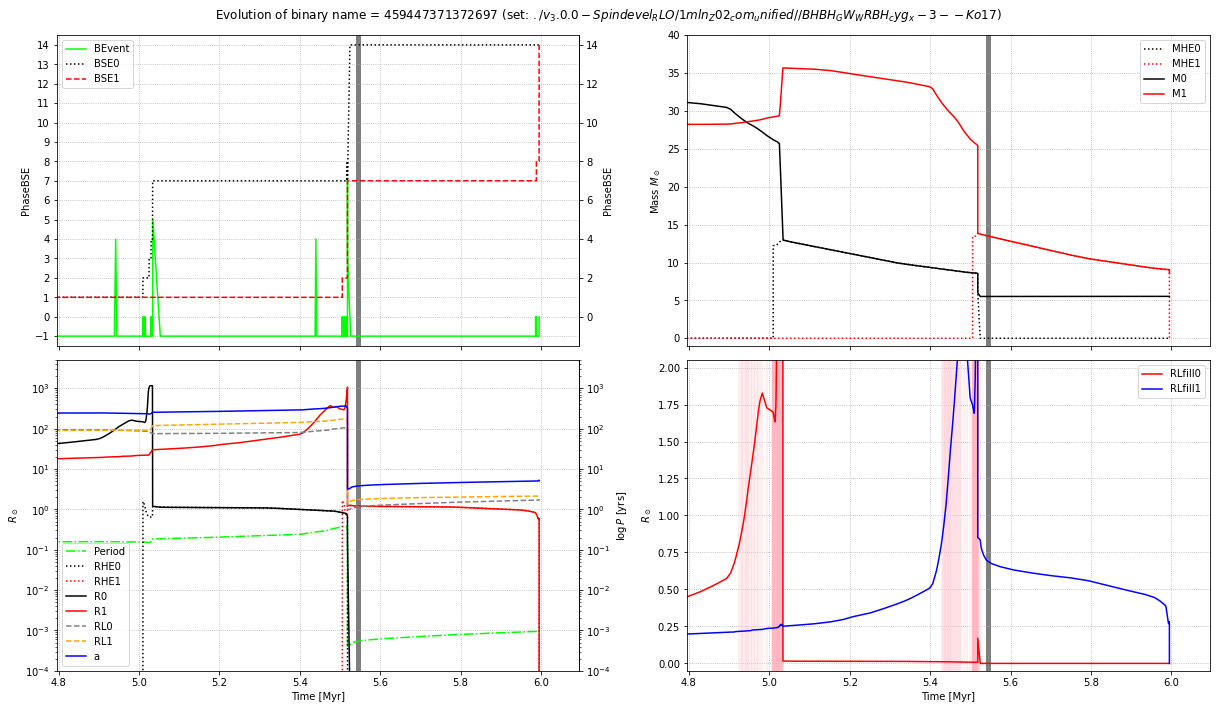

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


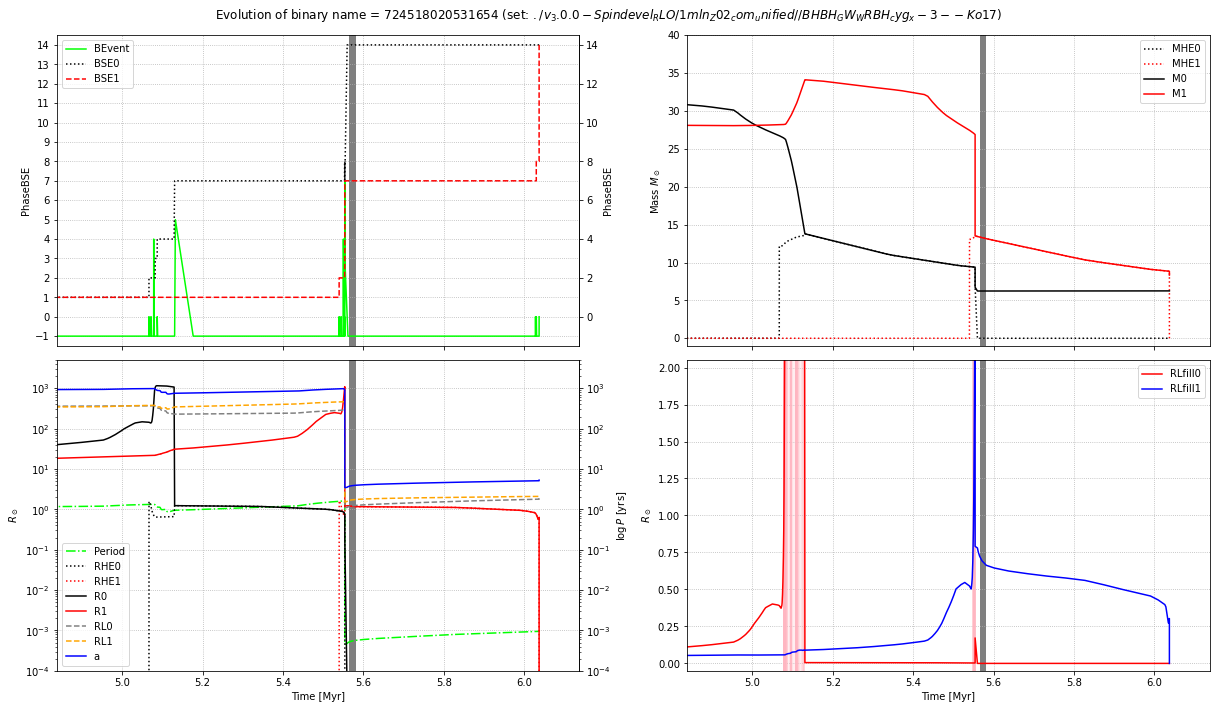

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


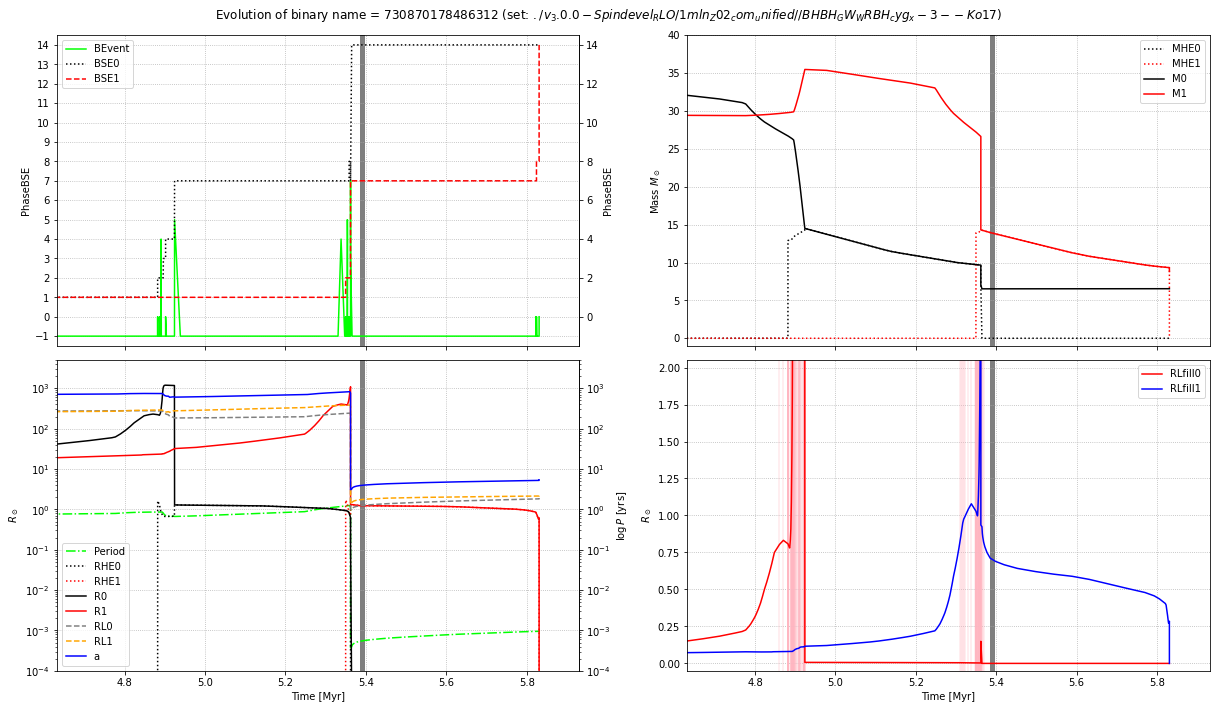

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


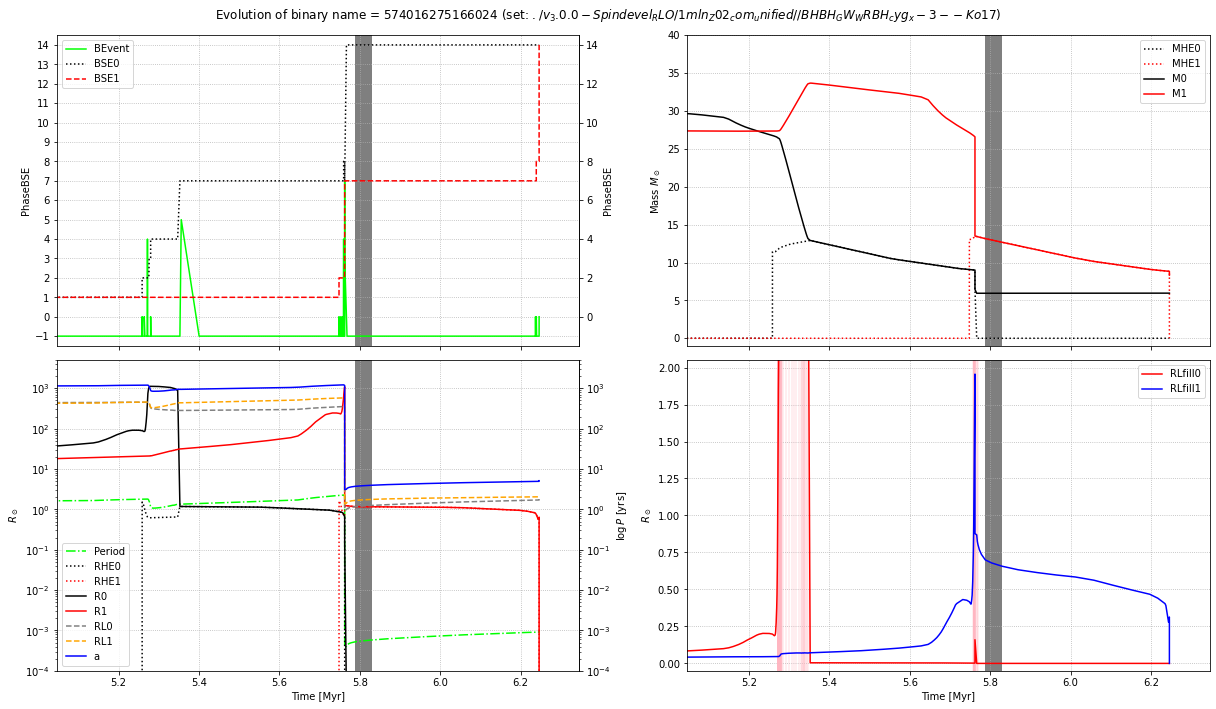

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


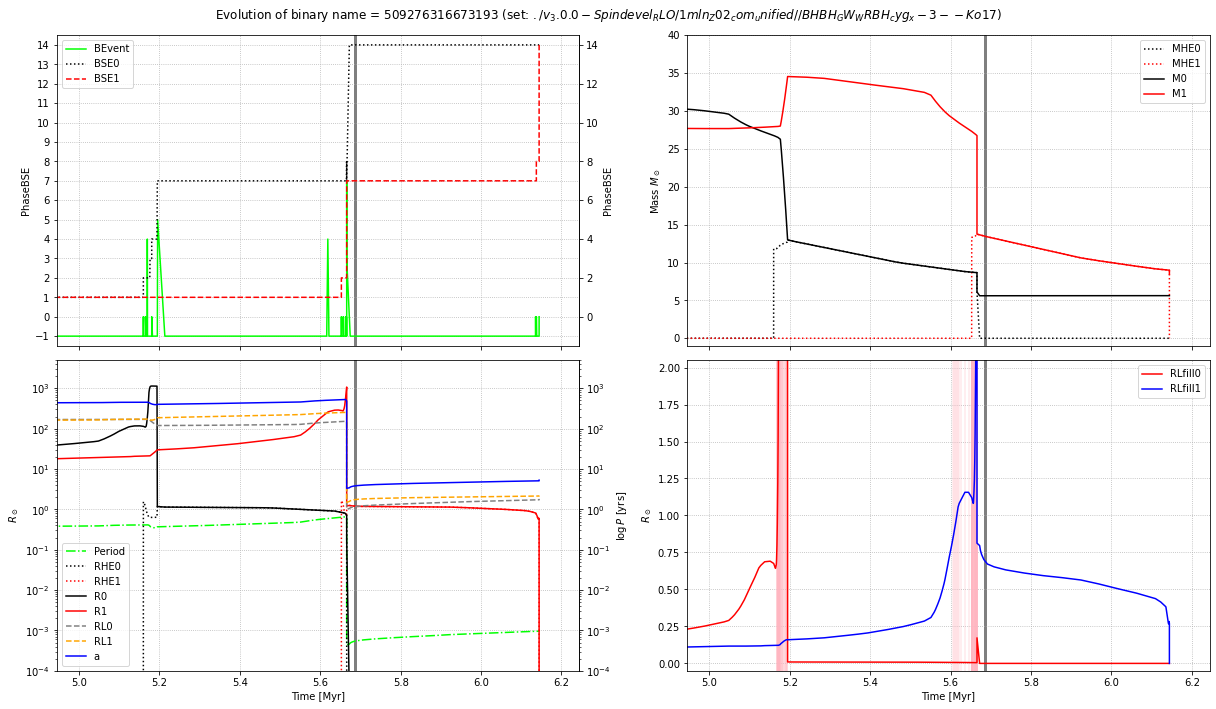

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


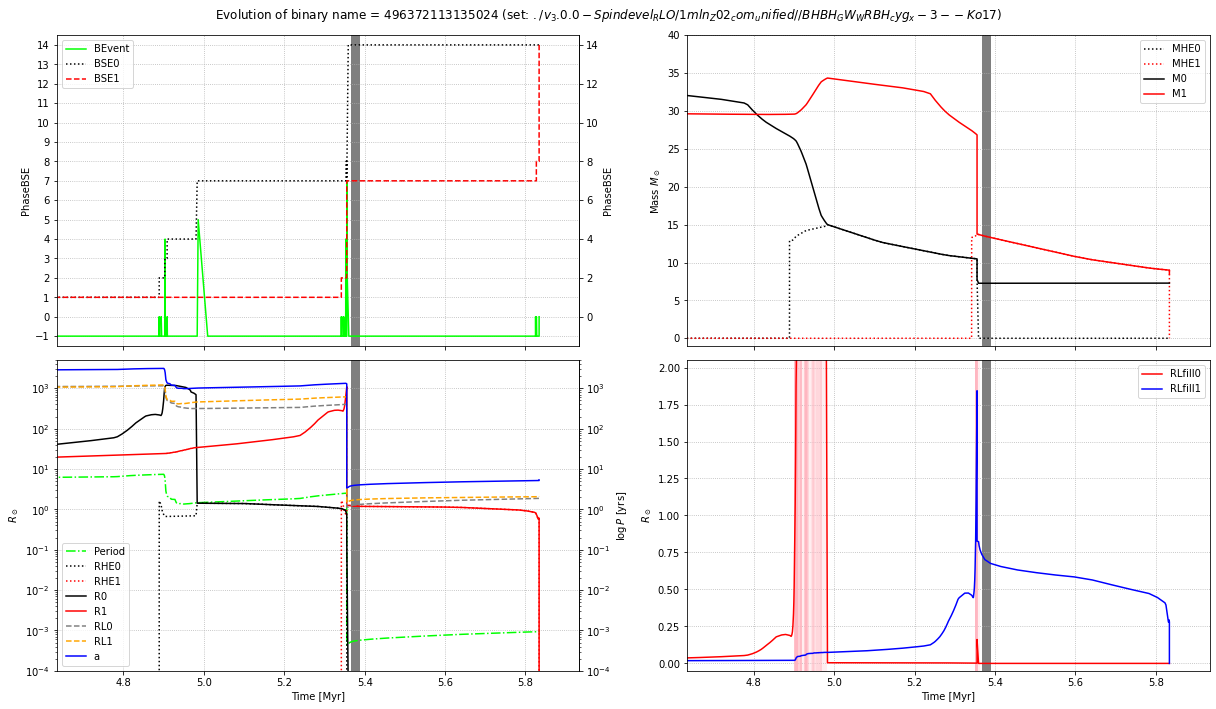

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


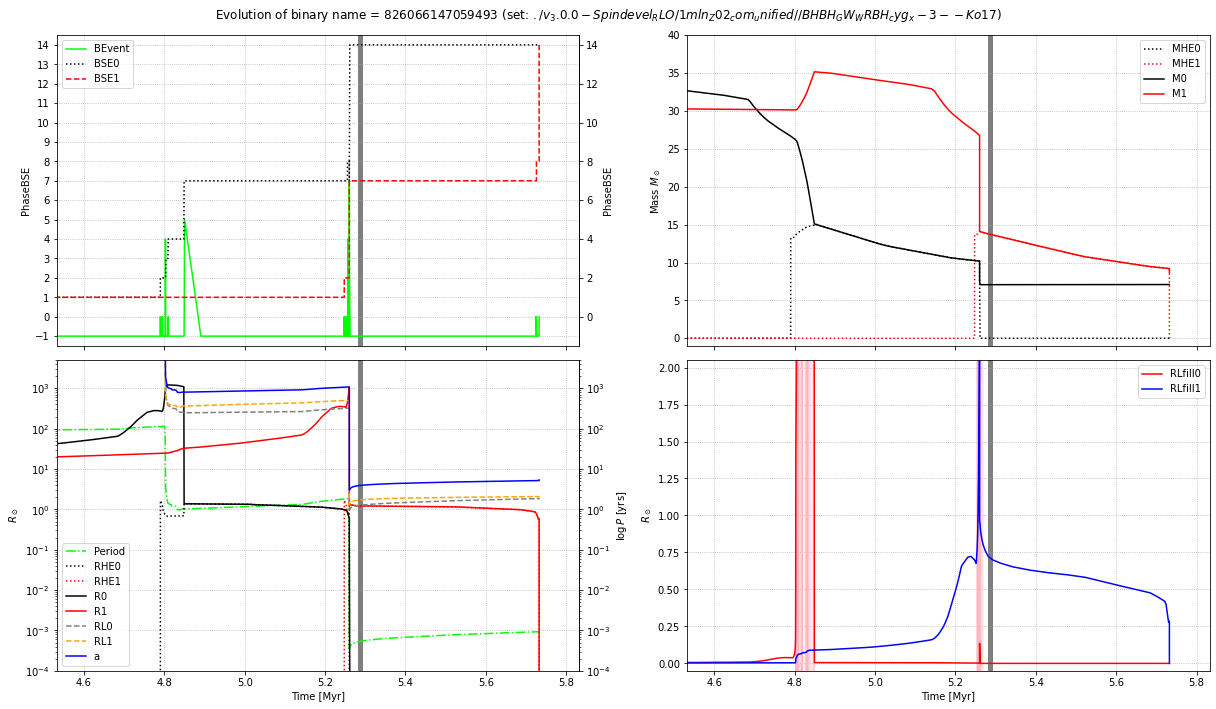

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


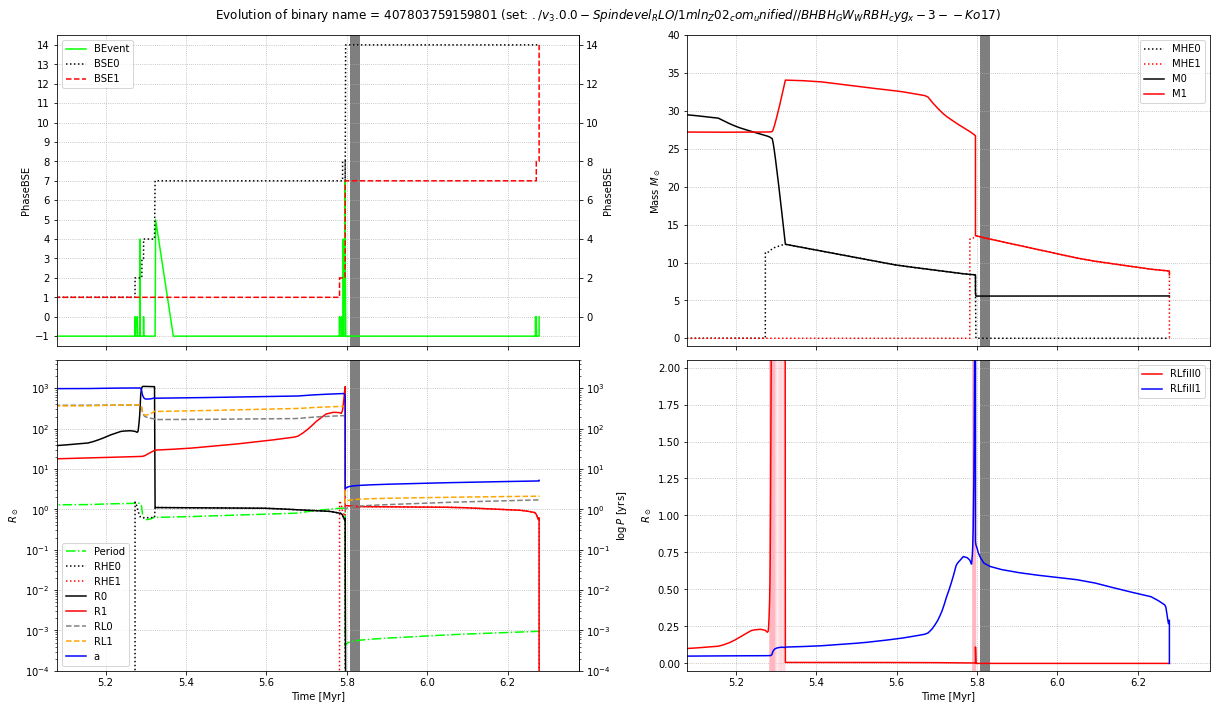

rap


/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


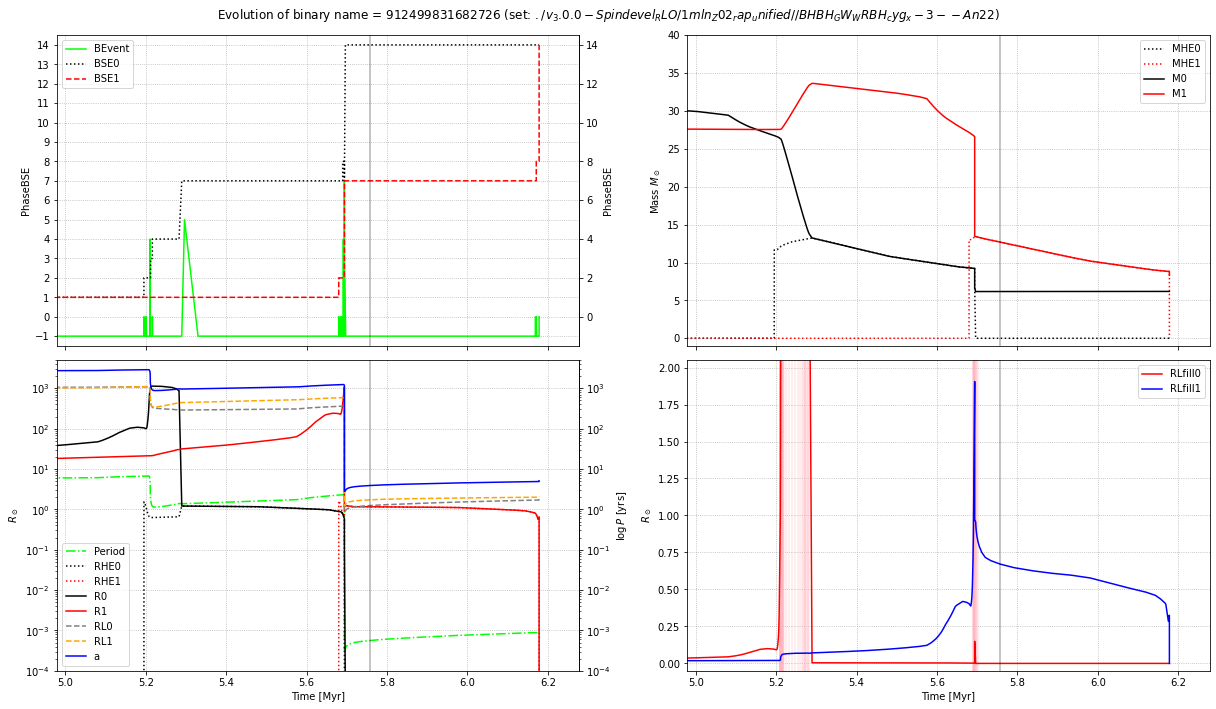

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


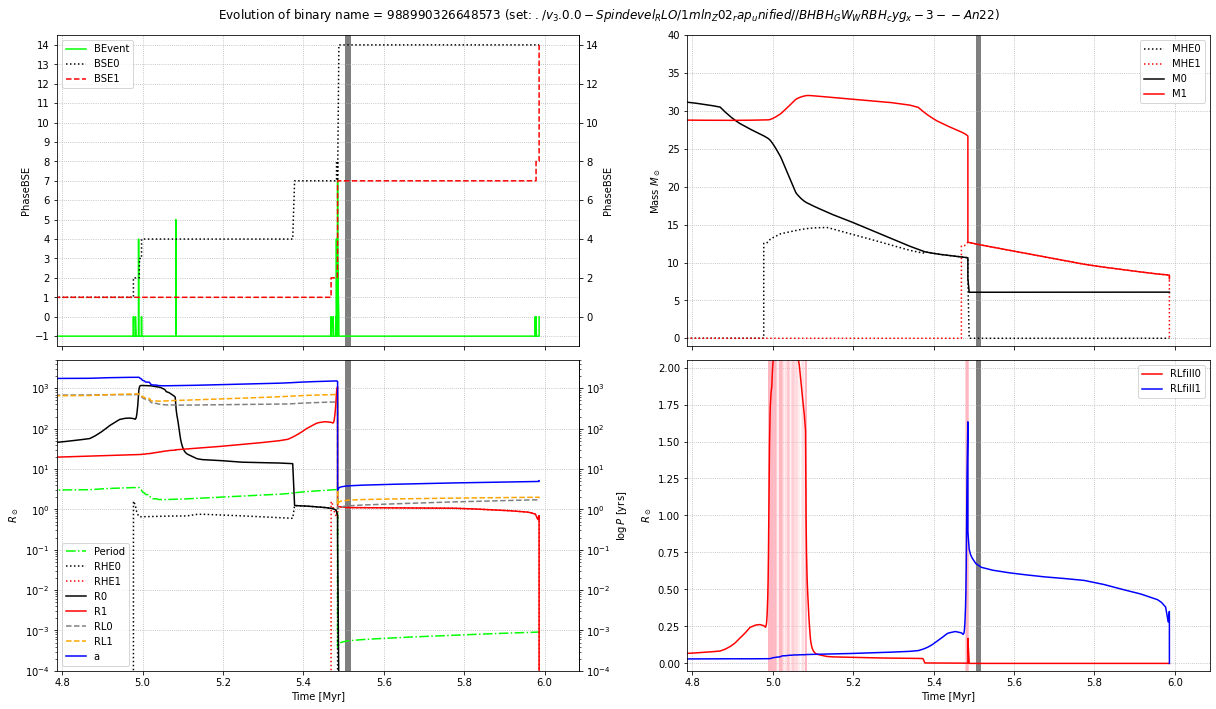

com


/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


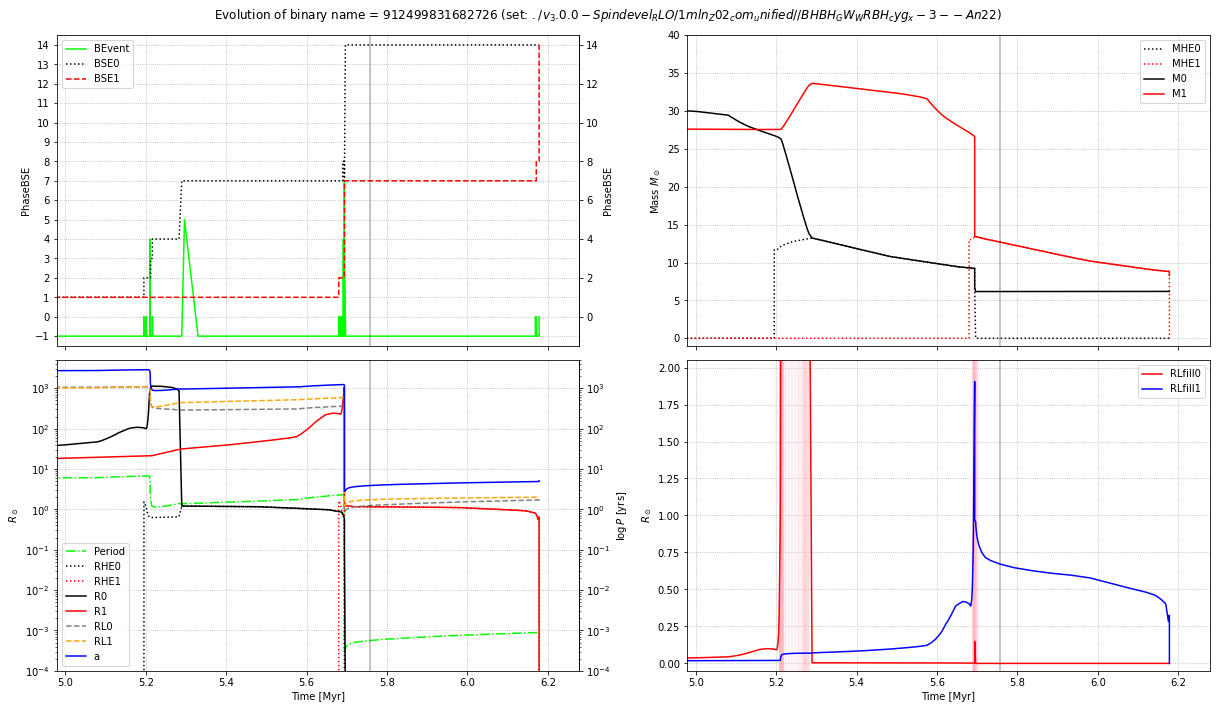

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


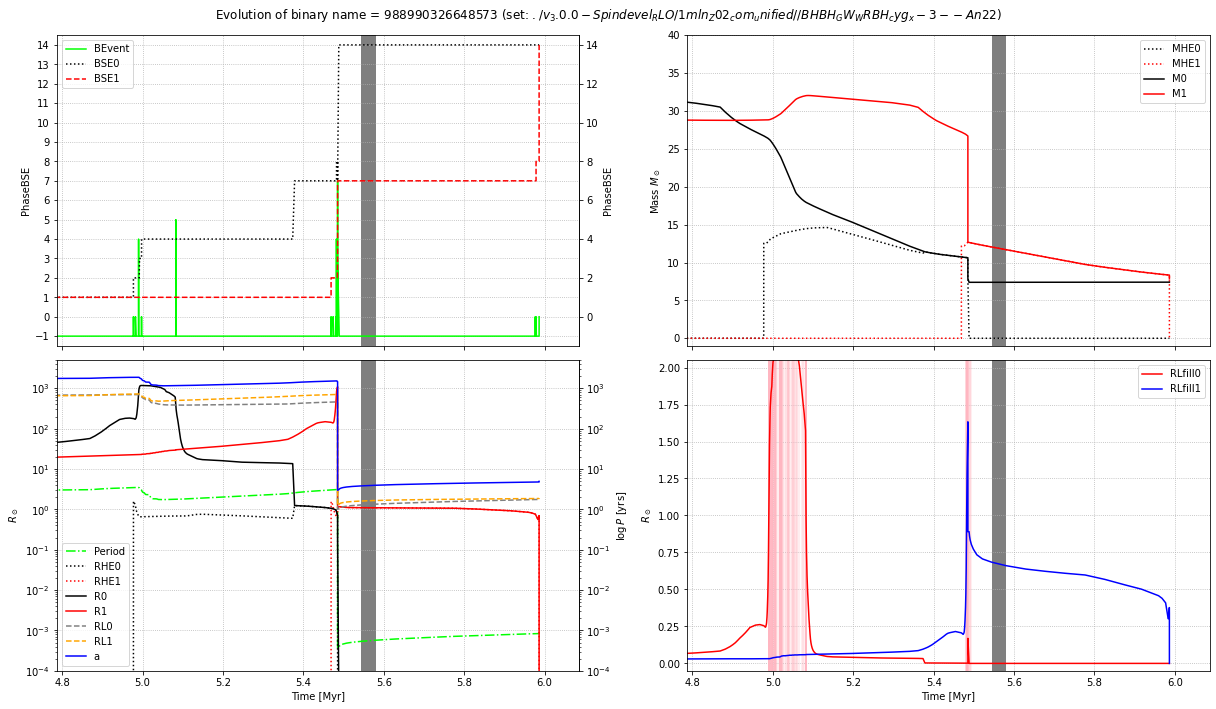

In [331]:
# only for common candidates

for kick in kicks:
    path_kick = f'./v_{version}/Z{Z}_{kick}'
    
    for mrange in mranges:
        df_name = f'{bintype}_{obs}--{mrange}'
        
        # read list of candidate names for a given SN and mass range
        try:
            common_read = pd.read_csv(f'{path_kick}/common_{mrange}_{commonSNs[0]}_{commonSNs[1]}.txt',header=None)
            common_read = common_read[0].to_list()
            common = list(map(str,map(int,common_read))) # convert into list of strings
        except pd.errors.EmptyDataError:
            common = []
        
        if len(common) !=0: 
            for SN in commonSNs:
                print(SN)
                ########################################################
                ########     preparation of mrange dataframes     ######
                ########################################################
                path_plot = f'{path_kick}/plot_common_{mrange}_{commonSNs[0]}_{commonSNs[1]}'
                os.makedirs(path_plot, exist_ok=True)

                # all timesteps of single simulation
                path_set = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/'
                df = pd.read_csv(f'{path_set}/{df_name}/run_scripts/sevn_output/output_0.csv')


                # original results of initial and final configurations while in WRBH phase
                i = pd.read_csv(f'{path_set}/dataframes/initial_WRBH/i_{df_name}.csv')
                f = pd.read_csv(f'{path_set}/dataframes/final_WRBH/f_{df_name}.csv')

                # for graphical limitations
                r = pd.read_csv(f'{path_set}/dataframes/remnants/r_{df_name}.csv')

                # set same dtype
                df.name = df.name.astype('string')
                i.name = i.name.astype('string')
                f.name = f.name.astype('string')
                r.name = r.name.astype('string')

                for name in common:
                    ########################################################
                    ########     preparation of  single dataframe     ######
                    ########################################################
                    # select binary of interest
                    binary = df.loc[df['name']==name]

    #                 # calculate parameters for collision
    #                 binary.loc[:,'R0+R1'] = binary.loc[:,'Radius_0']+binary.loc[:,'Radius_1']
    #                 binary.loc[:,'(1-e)a'] = (1-binary.loc[:,'Eccentricity'])*binary.loc[:,'Semimajor']
    #                 binary.loc[:,'coll']= binary.loc[:,'R0+R1'] >  binary.loc[:,'(1-e)a']
    #                 coll = binary.loc[binary['coll']==True]

                    # calculate where RL filling 
                    binary.loc[:,'RLfill0']= binary.loc[:,'Radius_0'] /  binary.loc[:,'RL0']
                    binary.loc[:,'RLfill1']= binary.loc[:,'Radius_1'] /  binary.loc[:,'RL1']
                    wind = binary.loc[(binary['RLfill0'] > 0.8) | (binary['RLfill1'] > 0.8)]



                    # select only while in observable configuration
                    time_min = i.loc[i['name']==name]['BWorldtime'].values[0]
                    time_max= f.loc[f['name']==name]['BWorldtime'].values[0]

                    # observable limit
                    time_end= r.loc[r['name']==name]['BWorldtime'].values[0]

                    ########################################################
                    ###############     actual plot         ################
                    ########################################################
                    ### plot ###
                    fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True,figsize = (17,10))
                    fig.suptitle(f'Evolution of binary name = {name} (set: ${path_set}/{df_name}$)')


                    axs[0][0].set_yticks(np.arange(-2,17+1,1))
                    binary.plot(x='BWorldtime',y='BEvent', ax=axs[0][0], color='lime').set(xlabel=r'Time [Myr]',ylabel=r'BEvent')
                    axs[0][0].axvspan(time_min, time_max, 0 ,1, facecolor='k',alpha=0.5)

                    binary.plot(x='BWorldtime',y='PhaseBSE_0', ax=axs[0][0], color='k', linestyle='dotted',label='BSE0')
                    binary.plot(x='BWorldtime',y='PhaseBSE_1', ax=axs[0][0], color='r', linestyle='dashed',label='BSE1').set(xlabel=r'Time [Myr]',ylabel=r'PhaseBSE')
                    secaxy=axs[0][0].secondary_yaxis('right',functions=(lambda x: x, lambda x: x))
                    secaxy.set_ylabel(r'PhaseBSE')
                    axs[0][0].grid(ls=':')


                    # axs[1][0].plot(binary['BWorldtime'],binary['Period']*24*365,  linestyle='dashdot',color='lime',label='P')
                    binary.plot(x='BWorldtime',y='Period', ax=axs[1][0], linestyle='dashdot',color='lime')
                    secaxy=axs[1][0].secondary_yaxis('right',functions=(lambda x: x, lambda x: x))
                    secaxy.set_ylabel(r'$\log P$ [yrs]')
                    secaxy.set_yscale('log')

                    binary.plot(x='BWorldtime',y='RHE_0', ax=axs[1][0], color='k', linestyle='dotted', label='RHE0')
                    binary.plot(x='BWorldtime',y='RHE_1', ax=axs[1][0], color='r', linestyle='dotted',label='RHE1')
                    binary.plot(x='BWorldtime',y='Radius_0', ax=axs[1][0], color='k', label='R0')
                    binary.plot(x='BWorldtime',y='Radius_1', ax=axs[1][0], color='r', label='R1')
                    binary.plot(x='BWorldtime',y='RL0', ax=axs[1][0], linestyle='dashed', color='grey', label='RL0')
                    binary.plot(x='BWorldtime',y='RL1', ax=axs[1][0], linestyle='dashed', color='orange', label='RL1')
                    binary.plot(x='BWorldtime',y='Semimajor', ax=axs[1][0], color='blue', label='a').set(xlabel=r'Time [Myr]',ylabel=r'$R_\odot$')
                    axs[1][0].axvspan(time_min, time_max, 0 ,1, facecolor='k',alpha=0.5)
                    axs[1][0].set_yscale('log')
                    axs[1][0].grid(ls=':')


                    binary.plot(x='BWorldtime',y='MHE_0', ax=axs[0][1], color='k', linestyle='dotted', label='MHE0')
                    binary.plot(x='BWorldtime',y='MHE_1', ax=axs[0][1], color='r', linestyle='dotted',label='MHE1')
                    binary.plot(x='BWorldtime',y='Mass_0', ax=axs[0][1], color='k', label='M0')
                    binary.plot(x='BWorldtime',y='Mass_1', ax=axs[0][1], color='r', label='M1').set(xlabel=r'Time [Myr]',ylabel=r'Mass $M_\odot$')
                    axs[0][1].axvspan(time_min, time_max, 0 ,1, facecolor='k',alpha=0.5)
                    axs[0][1].grid(ls=':')


                    # only if there are wind fed systems visualize them    
                    if not wind.empty:    
                        times_wind = wind['BWorldtime'].values
                        for time in times_wind:  
        #                     axs[0][0].axvline(x=time, color='dodgerblue', alpha=0.3)
        #                     axs[0][1].axvline(x=time, color='dodgerblue',alpha=0.3)
        #                     axs[1][0].axvline(x=time, color='dodgerblue',alpha=0.3)
                            axs[1][1].axvline(x=time, color='lightpink',alpha=0.3)



    #                 #binary.plot(x='BWorldtime',y='Eccentricity', ax=axs[1][1], color='red', label='e')
    #                 binary.plot(x='BWorldtime',y='R0+R1', ax=axs[1][1], color='red', label='R0+R1')
    #                 binary.plot(x='BWorldtime',y='(1-e)a', ax=axs[1][1], color='blue', label='(1-e)a').set(xlabel=r'Time [Myr]',ylabel=r'$R_\odot$')
                    binary.plot(x='BWorldtime',y='RLfill0', ax=axs[1][1], color='red', label='RLfill0')
                    binary.plot(x='BWorldtime',y='RLfill1', ax=axs[1][1], color='blue', label='RLfill1').set(xlabel=r'Time [Myr]',ylabel=r'$R_\odot$')


                    #axs[1][1].set_yscale('log')
                    axs[1][1].axvspan(time_min, time_max, 0 ,1, facecolor='k',alpha=0.5)
                    axs[1][1].grid(ls=':')



                    # if only a timestep is selected for observability
                    if time_max ==time_min:
                        axs[0][0].axvline(x=time_min, color='k', alpha=0.3)
                        axs[0][1].axvline(x=time_min, color='k',alpha=0.3)
                        axs[1][0].axvline(x=time_min, color='k',alpha=0.3)
                        axs[1][1].axvline(x=time_min, color='k',alpha=0.3)

        #                 # only if there are collision visualize them    
        #                 if not coll.empty:    
        #                     times = coll['BWorldtime'].values
        #                     for time in times:  
        #     #                     axs[0][0].axvline(x=time, color='dodgerblue', alpha=0.3)
        #     #                     axs[0][1].axvline(x=time, color='dodgerblue',alpha=0.3)
        #     #                     axs[1][0].axvline(x=time, color='dodgerblue',alpha=0.3)
        #                         axs[1][1].axvline(x=time, color='dodgerblue',alpha=0.3)


                    # set limits
                    xmin, xmax = time_end-1.2, time_end+0.1
                    axs[0][0].set_xlim(xmin, xmax)
                    axs[0][1].set_xlim(xmin, xmax)
                    axs[1][0].set_xlim(xmin, xmax)
                    axs[1][1].set_xlim(xmin, xmax)

                    axs[0][0].set_ylim(-1.5, 14.5)
                    axs[0][1].set_ylim(-1, 40)
                    axs[1][0].set_ylim(1e-4, 5e3)
                    axs[1][1].set_ylim(-0.05, 2.05)
                    #axs[1][1].set_ylim(1e-4, 5e3)


                    ##########################################################
                    fig.subplots_adjust(wspace = 0.3 )
                    plt.tight_layout()
                    plt.show()
                    fig.savefig(f'{path_plot}/name{name}_Z{Z}_{SN}_{kick}.jpg')

# Common plots

In [8]:
### set parameters for plots ###
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 20})
lw = 2.5  # linewidth
if obs == 'cyg_x-3':
    observed = 'Cyg X-3'

# Effect of kicks

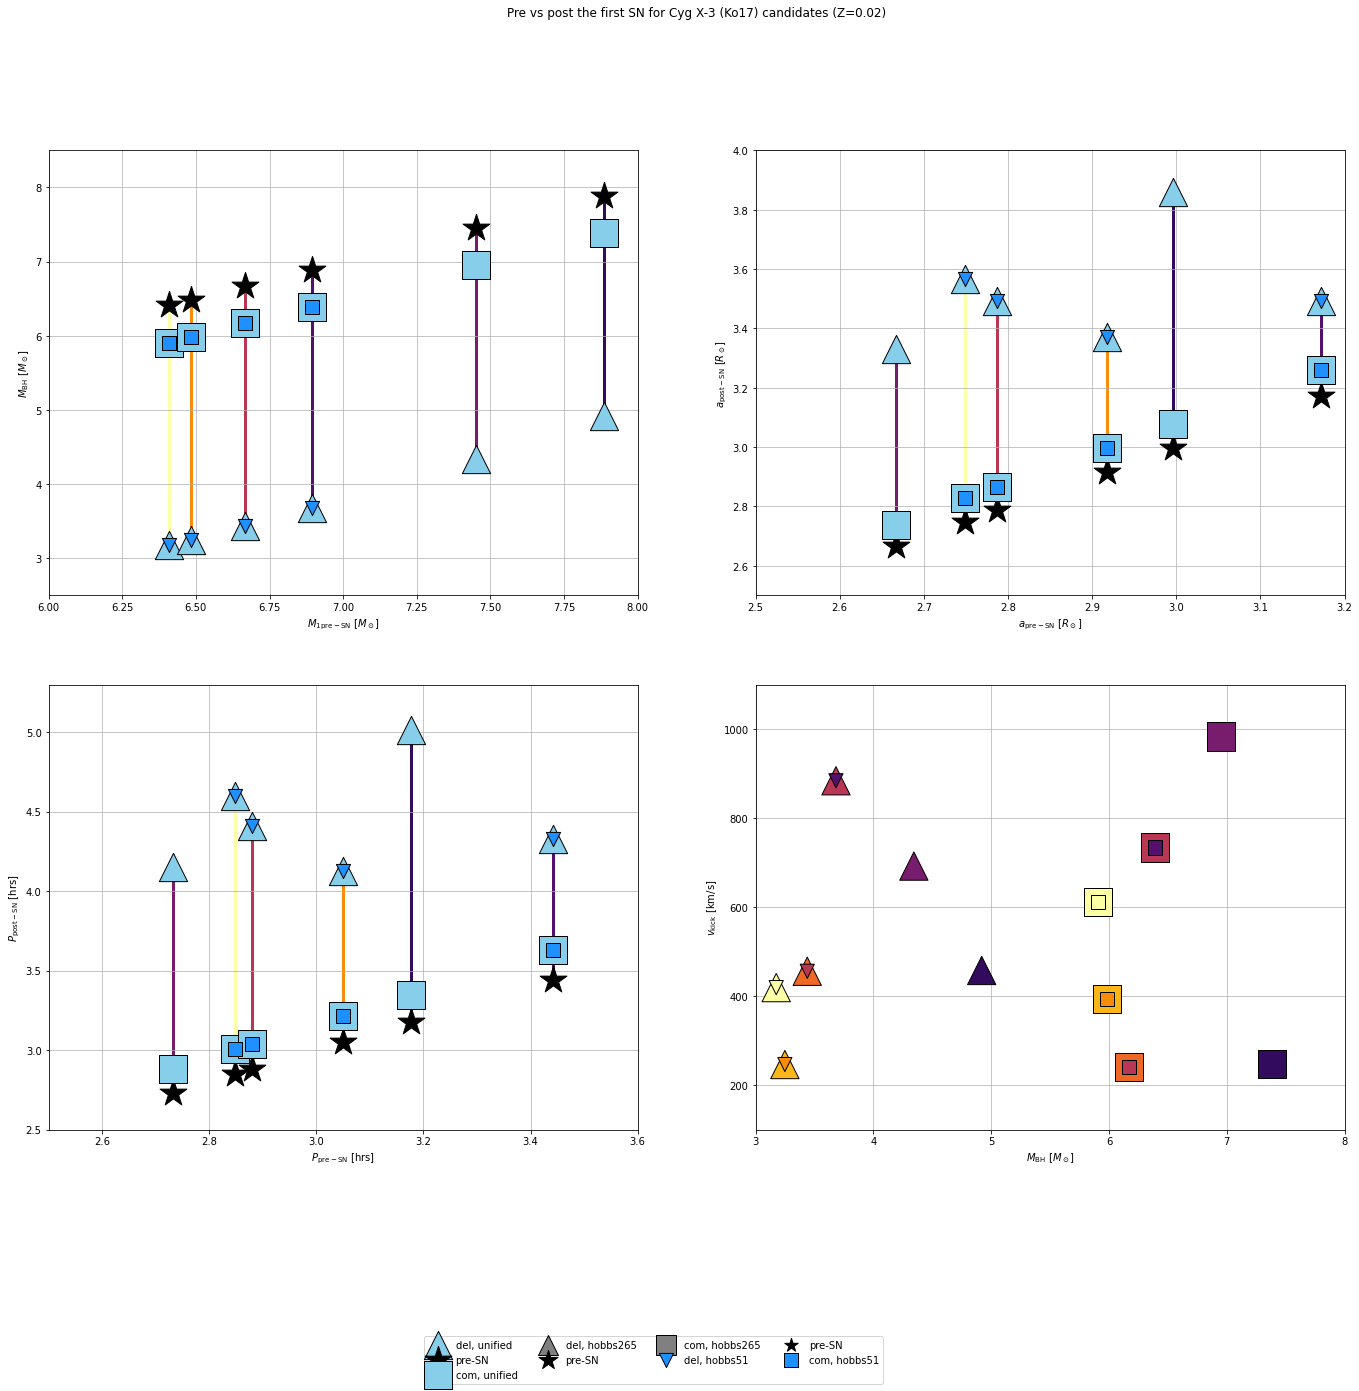

In [301]:
# plottype = 'pre_post_SN'

# #### preliminary select subset of interest ###
# mrange = 'Ko17'
# df_name = f'{bintype}_{obs}--{mrange}'
# path_plot = f'./v_{version}/'

# # physical costants
# G4pi2 =  9953108.1      # G/(4 pi^2) in units of R_sun^3/(M_sun yr^2)



# #####################
# ### prepare plot ####
# #####################
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
# fig.suptitle(f'Pre vs post the first SN for {observed} ({mrange}) candidates (Z=0.{Z})')

# Z_list = [f'{Z}',f'{Z}']
# #SN_list = ['del','com']
# #SN_list = commonSNs
# markers = ['^','o']
# cmaps = ['Reds','Greys','Blues','Greens']
# xlabels = [r'$M_{1 \rm pre-SN} ~ [M_\odot]$',r'$a_{\rm pre-SN} ~ [R_\odot]$', r'$P_{\rm pre-SN}$ [hrs]', r'$M_{\rm BH} ~ [M_\odot]$']
# ylabels = [r'$M_{\rm BH} ~ [M_\odot]$',r'$a_{\rm post-SN} ~ [R_\odot]$', r'$P_{\rm post-SN}$ [hrs]', r'$v_{\rm kick}$ [km/s]']
# #versions = ['3.0.0-Spindevel_RLO']





# for kick in kicks:
#     if kick == 'unified':
#         markers = ['^','s']
#         leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
#         size=800
#         scatter_colors = ['skyblue','skyblue']       
#     elif kick == 'hobbs265':
#         markers = ['^','s']
#         leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
#         size = 400
#         scatter_colors = ['grey','grey']
#     elif kick == 'hobbs51':
#         markers = ['v','s']
#         leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
#         size = 200
#         scatter_colors = ['dodgerblue','dodgerblue']

        
        
#     # read list of common candidate names for the fixed mass range between the desired SN models
#     path_kick = f'./v_{version}/Z{Z}_{kick}'
#     try:
#         common_read = pd.read_csv(f'{path_kick}/common_{mrange}_{commonSNs[0]}_{commonSNs[1]}.txt',header=None)
#         common_read = common_read[0].to_list()
#         commons = list(map(str,map(int,common_read))) # convert into list of strings
#     except pd.errors.EmptyDataError:
#         commons = []


#     # prepare colors for lines
#     NUM_COLORS = len(commons)
#     cm = plt.get_cmap('inferno_r')
#     colors=[]
#     for i in range(NUM_COLORS):
#         colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
        
    
    
#     for Z,SN,leglabel,marker,sc_color in zip(Z_list,commonSNs,leglabels,markers,scatter_colors):
#         ### set paths ###
#         path = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}'          # folder path identifier for a specific simulation run

#         ############################################
#         ########### extract SN infos  ##############
#         ############################################
#         path_log = f'{path}/{df_name}/run_scripts/sevn_output/logfile_0.dat'    
#         log = pd.read_csv(f'{path_log}')


#         ### extract SN events from the logfile ###
#         # logfile BSN lines have the following structure
#         # B;name;ID;BSN;time;ID_0:M_tot0:M_He0:M_CO0:phase0:remtype0:ID_1:M_tot1:M_He1:M_CO1:phase1:remtype1:ain:ein:aout...........:eout:cos:vCM
#         # where M_tot,M_He,M_CO are before the SN explosion
#         exp = "\d+\.\d+[eE][+-]\d+"   # exponential
#         regex_strBSN1=f'B;(\d+);\d+;BSN;(\d+.\d+);0:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+:(\d+.\d+):'
#         regex_strBSN2=f'B;(\d+);\d+;BSN;(\d+.\d+);0:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+.\d+:(\d+.\d+):'
#         #
#         # logfile BSN lines have the following structure
#         # S;name;ID;SN;time;M_tot:M_He:M_CO:M_rem:rem_type:vkick
#         # where M_tot,M_He,M_CO are before the SN explosion
#         regex_strSN='S;(\d+);0;SN;(\d+.\d+);(\d+.\d+):\d+.\d+:\d+.\d+:(\d+.\d+):\d+:(\d+.\d+):'

#         with open(path_log,"r") as f:
#             BSN1_mask = re.findall(regex_strBSN1,f.read())             #Find al the BSN occurence
#         with open(path_log,"r") as f:
#             BSN2_mask = re.findall(regex_strBSN2,f.read())             #Find al the BSN occurence
#         with open(path_log,"r") as f:
#             SN_mask = re.findall(regex_strSN,f.read())             #Find al the SN occurence

#         # convert into dataframes
#         colBSN_names = ['name','time','Mtot0','Mtot1','ain','aout']
#         BSN1 = pd.DataFrame(BSN1_mask, columns=colBSN_names)   # convert into pandas dataframe
#         BSN2 = pd.DataFrame(BSN2_mask, columns=colBSN_names)   # convert into pandas dataframe
#         BSN = pd.concat([BSN1,BSN2])
        

#         colSN_names = ['name','time','Mtot','Mrem','vkick']
#         SNdf = pd.DataFrame(SN_mask, columns=colSN_names)   # convert into pandas dataframe

#         # specify types of columns
#         BSN.name=BSN.name.astype('str')
#         BSN.Mtot0=BSN.Mtot0.astype('float')
#         BSN.Mtot1=BSN.Mtot1.astype('float')
#         BSN.ain=BSN.ain.astype('float')
#         BSN.aout=BSN.aout.astype('float')
#         SNdf.name=SNdf.name.astype('str')
#         SNdf.Mrem=SNdf.Mrem.astype('float')
#         SNdf.vkick=SNdf.vkick.astype(float)


#         #select only rows of interest
#         BSN = BSN.loc[BSN['name'].isin(commons)].sort_values('name')
#         SNdf = SNdf.loc[SNdf['name'].isin(commons)].sort_values('name')
#         df = pd.concat([BSN,SNdf[['Mrem','vkick']]],axis=1).sort_values('Mtot0')


#         # add columns for period in yrs
#         # assume the SN happens only for star0, therefore Mass1 is the same as before the SN
#         df['Pin'] = np.sqrt(df['ain']**3 / (G4pi2*(df['Mtot0']+df['Mtot1']))) # Kepler 3rd law
#         df['Pout'] = np.sqrt(df['aout']**3 / (G4pi2*(df['Mrem']+df['Mtot1']))) # Kepler 3rd law

#         df['Pin'] = df['Pin']*365*24     # convert in hours
#         df['Pout'] = df['Pout']*365*24
    
    
    

#         # prepare values to scatter on x and y axis
#         xs = [df['Mtot0'],df['ain'], df['Pin'], df['Mrem']]
#         ys = [df['Mrem'],df['aout'], df['Pout'],df['vkick']]
        


#         ############################################
#         ########### plot  #########################
#         ############################################

#         for ax,x,y,xlabel,ylabel in zip (axs.flat,xs,ys,xlabels,ylabels):
#             if ax!= axs[1][1]:
#                 ax.scatter(x,y, marker=marker,edgecolor='k',c=sc_color,s=size,label=leglabel,zorder=3)
#                 if (SN == SN_list[0]):
#                     for i,col in zip(range(0,len(commons)),colors):
#                         ax.plot([x.iloc[i],x.iloc[i]],[x.iloc[i],y.iloc[i]],color=col,lw=3,zorder=1)
#                     if kick_single == 'unified':
#                         ax.scatter(x,x, marker='*',edgecolor='k',c='k',s=size,label='pre-SN',zorder=2)



#             elif ax == axs[1][1]:
#                 ax.scatter(x,y, marker=marker,edgecolor='k',c=colors,s=size,label=SN,zorder=3)

#             ax.grid(alpha=0.9)


#             ax.set_xlabel(f'{xlabel}')
#             ax.set_ylabel(f'{ylabel}') 

        
#         axs[0][0].set_xlim(6,8)
#         axs[0][0].set_ylim(2.5,8.5)
#         axs[0][1].set_xlim(2.5,3.2)
#         axs[0][1].set_ylim(2.5,4.)
#         axs[1][0].set_xlim(2.5,3.6)
#         axs[1][0].set_ylim(2.5,5.3)
#         axs[1][1].set_xlim(3,8.)
#         axs[1][1].set_ylim(100.,1100.)

        
# handles, labels = axs[0][0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.48,0.02))   
# #plt.tight_layout()
# fig.subplots_adjust(bottom=0.2, left=0.2,right=0.8)

# plt.show()
# fig.savefig(f'{path_plot}Z{Z}_{plottype}_{mrange}.jpg')

In [416]:
mrange = 'Ko17'
SN = 'rap'
df_name = f'{bintype}_{obs}--{mrange}'

path = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick_single}'          # folder path identifier for a specific simulation run

############################################
########### extract SN infos  ##############
############################################
path_log = f'{path}/{df_name}/run_scripts/sevn_output/logfile_0.dat'    



def LogfileExtracBEvents(path_log):
    log = pd.read_csv(f'{path_log}')


    ### extract binary events from the logfile ###
    # logfile headerlines have the following structure
    # B;name;ID;event;time;ID_0:
    exp = "\d+\.\d+[eE][+-]\d+"   # exponential
    regex_str=f'B;(\d+);\d+;(\w+);(\d+.\d+);'

    with open(path_log,"r") as f:
        mask = re.findall(regex_str,f.read())             #Find al the BSN occurence

    # convert into dataframes
    col_names = ['name',f'BEvent',f'BWorldtime']
    B = pd.DataFrame(mask1, columns=col_names)   # convert into pandas dataframe
    
    B.name=B.name.astype('str')
    B.BWorldtime=B.BWorldtime.astype('float')
    return B


In [420]:
# extract BEvents
B = LogfileExtracBEvents(path_log)
# extract data for second SN
SN2 = LogfileExtractSN(path_log,nSN=1)

# select only names of candidates of interest, since the logfile contains all simulated candidates
try:
    path_kick = f'./v_{version}/Z{Z}_{kick_single}'
    names_read = pd.read_csv(f'{path_kick}/{mrange}_{SN}_{bintype}_{obs}.txt',header=None)
    names_read = names_read[0].to_list()
    names = list(map(str,map(int,names_read))) # convert into list of strings
except pd.errors.EmptyDataError:
    names = []

SN2 = SN2.loc[SN2['name'].isin(names)]
B = B.loc[B['name'].isin(names)]
# 
for name in names:
    # second SN timestamp
    timeSN2 = SN2.time.loc[SN2['name'] == name].to_numpy()[0]
    # select single sub-dataframe
    Bbin = B.loc[B['name'] == name]#.sort_values('BWorldtime')   
    print(Bbin,timeSN2)

              name     BEvent  BWorldtime
0  988990326648573  RLO_BEGIN    4.989976
1  988990326648573    RLO_END    5.082687
2  988990326648573  RLO_BEGIN    5.482108
3  988990326648573         CE    5.485171
4  988990326648573    RLO_END    5.485171
5  988990326648573        BSN    5.485171
6  988990326648573        BSN    5.986453 5.986453
               name     BEvent  BWorldtime
7   455693667789171  RLO_BEGIN    4.976816
8   455693667789171    RLO_END    5.024244
9   455693667789171  RLO_BEGIN    5.444838
10  455693667789171         CE    5.448741
11  455693667789171    RLO_END    5.448741
12  455693667789171        BSN    5.448741
13  455693667789171        BSN    5.924846 5.924846
               name     BEvent  BWorldtime
14  912499831682726  RLO_BEGIN    5.210497
15  912499831682726    RLO_END    5.289342
16  912499831682726  RLO_BEGIN    5.691166
17  912499831682726         CE    5.693890
18  912499831682726    RLO_END    5.693890
19  912499831682726        BSN    5.693890
2

In [418]:
Bbin

name     BEvent  BWorldtime
107  724518020531654  RLO_BEGIN    5.078400
108  724518020531654    RLO_END    5.130545
109  724518020531654  RLO_BEGIN    5.550177
110  724518020531654         CE    5.553921
111  724518020531654    RLO_END    5.553921
112  724518020531654        BSN    5.553921
113  724518020531654        BSN    6.037242

In [10]:
# nSN refers to the first or to the second SN
# it is respectively equal to 0 or to 1
def LogfileExtractSN(path_log,nSN):    
    # logfile
    log = pd.read_csv(f'{path_log}')


    ### extract SN events from the logfile ###
    # logfile BSN lines have the following structure
    # B;name;ID;BSN;time;ID_0:M_tot0:M_He0:M_CO0:phase0:remtype0:ID_1:M_tot1:M_He1:M_CO1:phase1:remtype1:ain:ein:aout...........:eout:cos:vCM
    # where M_tot,M_He,M_CO are before the SN explosion
    exp = "\d+\.\d+[eE][+-]\d+"   # exponential
    regex_strBSN1=f'B;(\d+);\d+;BSN;(\d+.\d+);{nSN}:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+:(\d+.\d+):'
    regex_strBSN2=f'B;(\d+);\d+;BSN;(\d+.\d+);{nSN}:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+.\d+:(\d+.\d+):'
    #
    # logfile BSN lines have the following structure
    # S;name;ID;SN;time;M_tot:M_He:M_CO:M_rem:rem_type:vkick
    # where M_tot,M_He,M_CO are before the SN explosion
    regex_strSN=f'S;(\d+);{nSN};SN;(\d+.\d+);(\d+.\d+):\d+.\d+:\d+.\d+:(\d+.\d+):\d+:(\d+):'
    regex_strSN2=f'S;(\d+);{nSN};SN;(\d+.\d+);(\d+.\d+):\d+.\d+:\d+.\d+:(\d+.\d+):\d+:(\d+.\d+):'
    

    with open(path_log,"r") as f:
        BSN1_mask = re.findall(regex_strBSN1,f.read())             #Find al the BSN occurence
    with open(path_log,"r") as f:
        BSN2_mask = re.findall(regex_strBSN2,f.read())             #Find al the BSN occurence
    with open(path_log,"r") as f:
        SN_mask = re.findall(regex_strSN,f.read())             #Find al the SN occurence
    with open(path_log,"r") as f:
        SN_mask2 = re.findall(regex_strSN2,f.read())             #Find al the SN occurence

    # convert into dataframes
    colBSN_names = ['name','time',f'Mtot{nSN}',f'Mtot{1-nSN}','ain','aout']
    BSN1 = pd.DataFrame(BSN1_mask, columns=colBSN_names)   # convert into pandas dataframe
    BSN2 = pd.DataFrame(BSN2_mask, columns=colBSN_names)   # convert into pandas dataframe
    BSN = pd.concat([BSN1,BSN2])


    colSN_names = ['name','time','Mtot','Mrem','vkick']
    SNdf1 = pd.DataFrame(SN_mask, columns=colSN_names).reset_index(drop=True)   # convert into pandas dataframe
    SNdf2 = pd.DataFrame(SN_mask2, columns=colSN_names).reset_index(drop=True)   # convert into pandas dataframe
    
    # bug fix i.e. remove wrong kicks that are taken in the format ddd:d
    names_bug = SNdf1.name.to_list()
    for name in names_bug:
        SNdf2.drop(SNdf2.loc[SNdf2['name']==name].index, inplace=True)
    # concatenate
    SNdf = pd.concat([SNdf1,SNdf2])

    
    # specify types of columns
    BSN.name=BSN.name.astype('str')
    BSN.Mtot0=BSN.Mtot0.astype('float')
    BSN.Mtot1=BSN.Mtot1.astype('float')
    BSN.ain=BSN.ain.astype('float')
    BSN.aout=BSN.aout.astype('float')
    BSN.time=BSN.time.astype('float')
    SNdf.name=SNdf.name.astype('str')
    SNdf.Mrem=SNdf.Mrem.astype('float')
    SNdf.vkick=SNdf.vkick.astype('float')

    #BSN = BSN.loc[BSN['name'].isin(commons)].sort_values('name')
    #SNdf = SNdf.loc[SNdf['name'].isin(commons)].sort_values('name')
    
    # concatenate
    BSN = BSN.sort_values('name').reset_index(drop=True)
    SNdf = SNdf.sort_values('name').reset_index(drop=True)
    df = pd.concat([BSN,SNdf[['Mrem','vkick']]],axis=1)#.sort_values('name')


    # add columns for period in yrs
    # assume the SN happens only for star0, therefore Mass1 is the same as before the SN
    df['Pin'] = np.sqrt(df['ain']**3 / (G4pi2*(df['Mtot0']+df['Mtot1']))) # Kepler 3rd law
    df['Pout'] = np.sqrt(df['aout']**3 / (G4pi2*(df['Mrem']+df[f'Mtot{1-nSN}']))) # Kepler 3rd law

    df['Pin'] = df['Pin']*365*24     # convert in hours
    df['Pout'] = df['Pout']*365*24
    return df

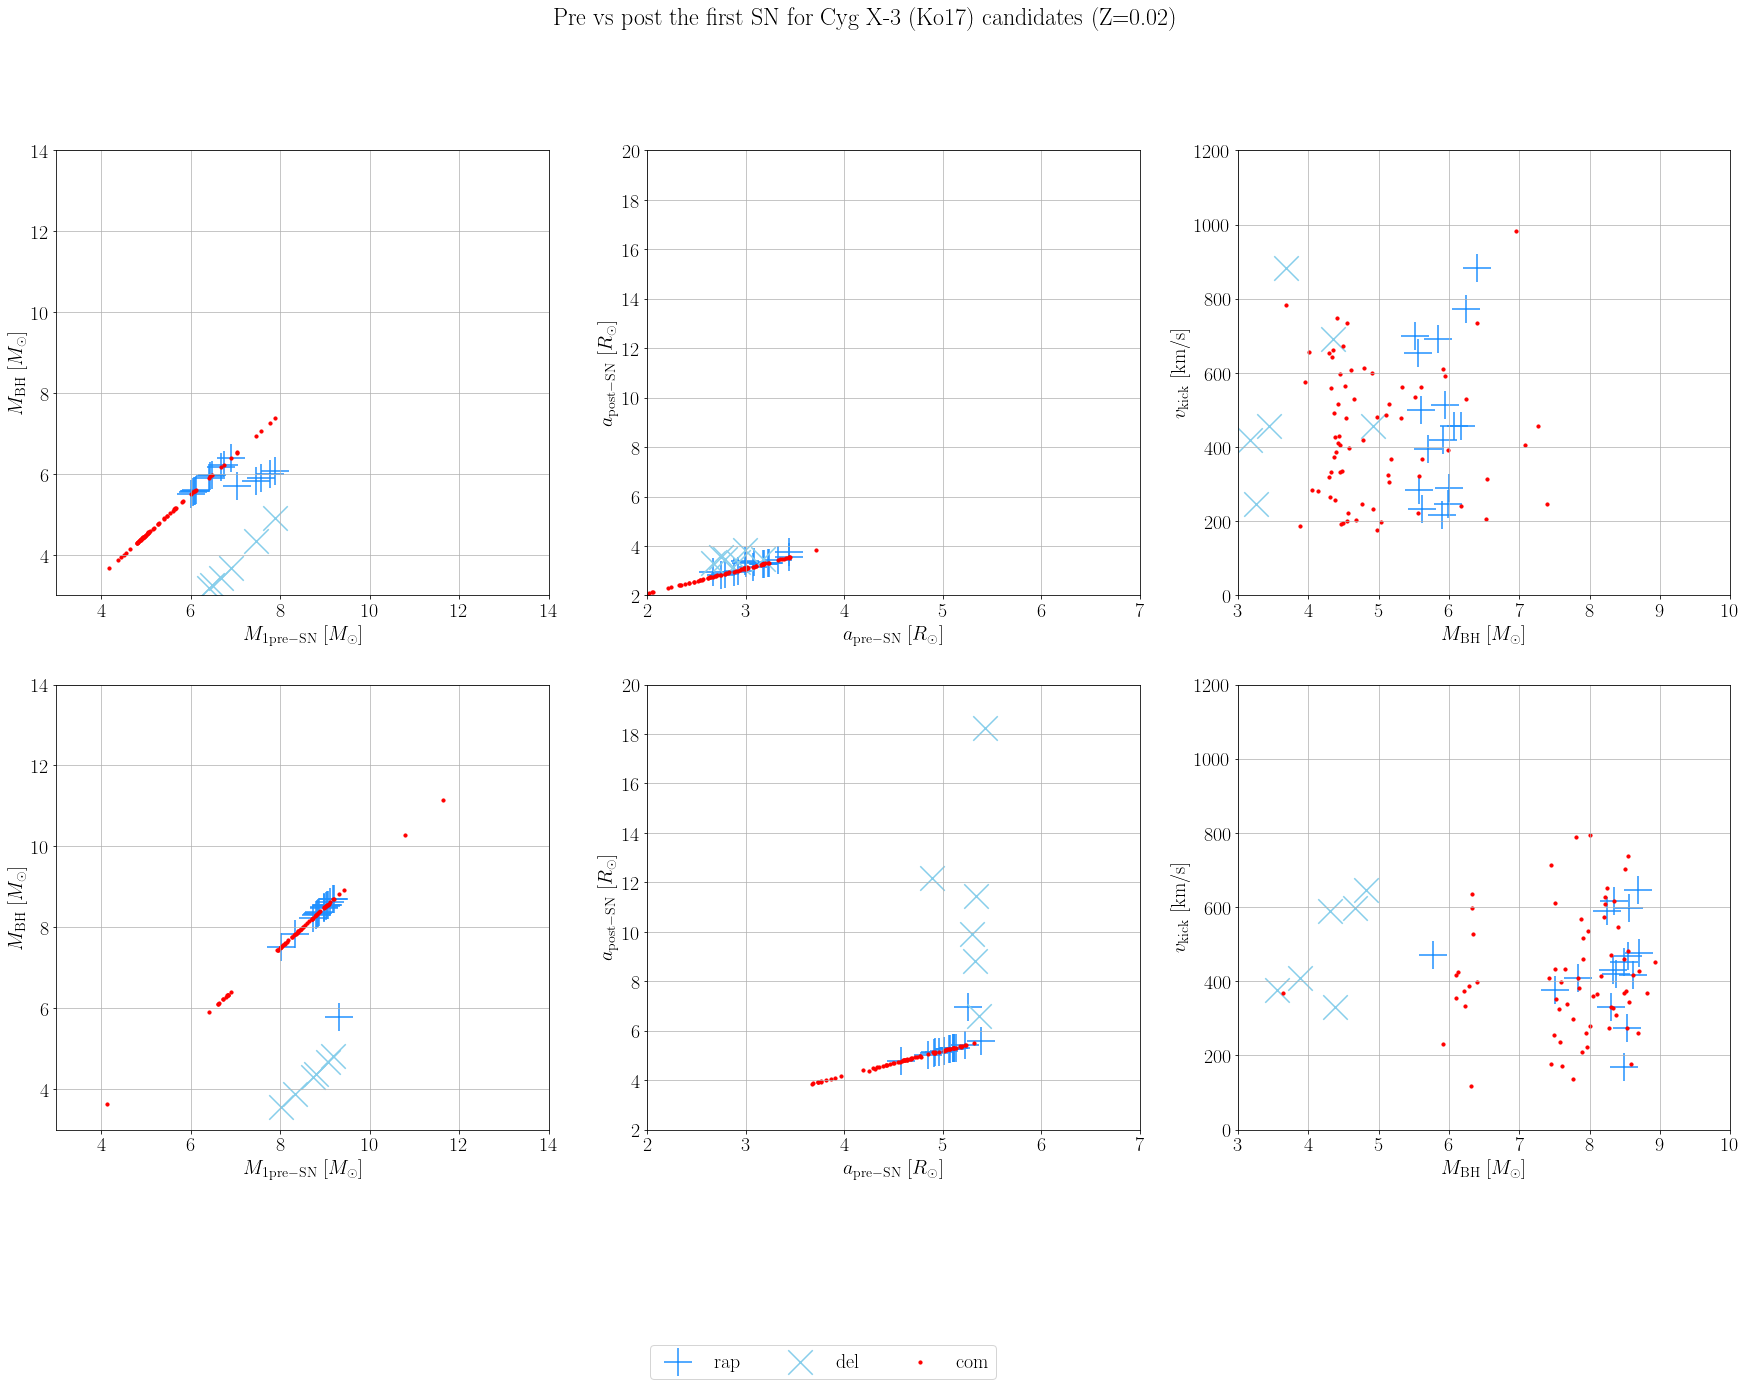

In [515]:
#### preliminary select subset of interest ###
mrange = 'Ko17'
df_name = f'{bintype}_{obs}--{mrange}'
path_plot = f'./v_{version}/'
plottype = f'pre_post_SN_{mrange}_{kick_single}'

# physical costants
G4pi2 =  9953108.1      # G/(4 pi^2) in units of R_sun^3/(M_sun yr^2)



#####################
### prepare plot ####
#####################
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
fig.suptitle(f'Pre vs post the first SN for {observed} ({mrange}) candidates (Z=0.{Z})')

#Z_list = [f'{Z}',f'{Z}']
#SN_list = ['del','com']
#SN_list = commonSNs
cmaps = ['Reds','Greys','Blues','Greens']
xlabels = [r'$M_{1 \rm pre-SN} ~ [M_\odot]$',r'$a_{\rm pre-SN} ~ [R_\odot]$', r'$M_{\rm BH} ~ [M_\odot]$',
          r'$M_{1 \rm pre-SN} ~ [M_\odot]$',r'$a_{\rm pre-SN} ~ [R_\odot]$', r'$M_{\rm BH} ~ [M_\odot]$']
ylabels = [r'$M_{\rm BH} ~ [M_\odot]$',r'$a_{\rm post-SN} ~ [R_\odot]$', r'$v_{\rm kick}$ [km/s]',
          r'$M_{\rm BH} ~ [M_\odot]$',r'$a_{\rm post-SN} ~ [R_\odot]$', r'$v_{\rm kick}$ [km/s]']
#versions = ['3.0.0-Spindevel_RLO']

markers = ['+','x','o']
#leglabels = [f'{SNs[0]}',f'{SNs[1]}',f'{SNs[2]}']
sizes= [800,600,10]
scatter_colors = ['dodgerblue','skyblue','red']       



        
        
# read list of common candidate names for the fixed mass range between the desired SN models
path_kick = f'./v_{version}/Z{Z}_{kick_single}'




# # prepare colors for lines
# NUM_COLORS = len(commons)
# cm = plt.get_cmap('inferno_r')
# colors=[]
# for i in range(NUM_COLORS):
#     colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple



for SN,marker,sc_color,size in zip(SNs,markers,scatter_colors,sizes):
#     try:
#         names_read = pd.read_csv(f'{path_kick}/{mrange}_{SN}_{df_name}.txt',header=None)
#         names_read = names_read[0].to_list()
#         names = list(map(str,map(int,names_read))) # convert into list of strings
#     except pd.errors.EmptyDataError:
#         names = []
    
    ### set paths ###
    path = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick_single}'          # folder path identifier for a specific simulation run

    ############################################
    ########### extract SN infos  ##############
    ############################################
    path_log = f'{path}/{df_name}/run_scripts/sevn_output/logfile_0.dat'    
    log = pd.read_csv(f'{path_log}')

    df = LogfileExtractSN(path_log,nSN=0)  
    df2 = LogfileExtractSN(path_log,nSN=1)  
    # prepare values to scatter on x and y axis
    xs = [df['Mtot0'],df['ain'],  df['Mrem'],df2['Mtot1'],df2['ain'],  df2['Mrem']]
    ys = [df['Mrem'],df['aout'], df['vkick'],df2['Mrem'],df2['aout'], df2['vkick']]
    
    



    ############################################
    ########### plot  #########################
    ############################################
    
    for ax,x,y,xlabel,ylabel in zip (axs.flat,xs,ys,xlabels,ylabels):
        #if (ax == axs[0][0]) | (ax == axs[0][1]) | (ax == axs[0][2]):
        ax.scatter(x,y, marker=marker,c=sc_color,s=size,label=SN)
#             elif  (ax == axs[1][0]) | (ax == axs[1][1]) | (ax == axs[1][2]): 
#                 print(xlabel)
#                 ax.scatter(x2,y2, marker=marker,edgecolor='k',c=sc_color,s=size,label=SN)
#         if (SN == SN_list[0]):
#             for i,col in zip(range(0,len(commons)),colors):
#                 ax.plot([x.iloc[i],x.iloc[i]],[x.iloc[i],y.iloc[i]],color=col,lw=3,zorder=1)
#             if kick_single == 'unified':
#                 ax.scatter(x,x, marker='*',edgecolor='k',c='k',s=size,label='pre-SN',zorder=2)


        ax.grid(alpha=0.9)


        ax.set_xlabel(f'{xlabel}')
        ax.set_ylabel(f'{ylabel}') 

        
        axs[0][0].set_xlim(3,14)
        axs[0][0].set_ylim(3,14)
        axs[0][1].set_xlim(2.,7.)
        axs[0][1].set_ylim(2.,20.)
        axs[0][2].set_xlim(3,10.)
        axs[0][2].set_ylim(0.,1200.)
        
        axs[1][0].set_xlim(3,14)
        axs[1][0].set_ylim(3,14)
        axs[1][1].set_xlim(2.,7.)
        axs[1][1].set_ylim(2.,20.)
        axs[1][2].set_xlim(3,10.)
        axs[1][2].set_ylim(0.,1200.)

        
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.48,0.02))   
#plt.tight_layout()
fig.subplots_adjust(bottom=0.2)

plt.show()
fig.savefig(f'{path_plot}Z{Z}_{plottype}_{mrange}.jpg')

# General GW-BBH

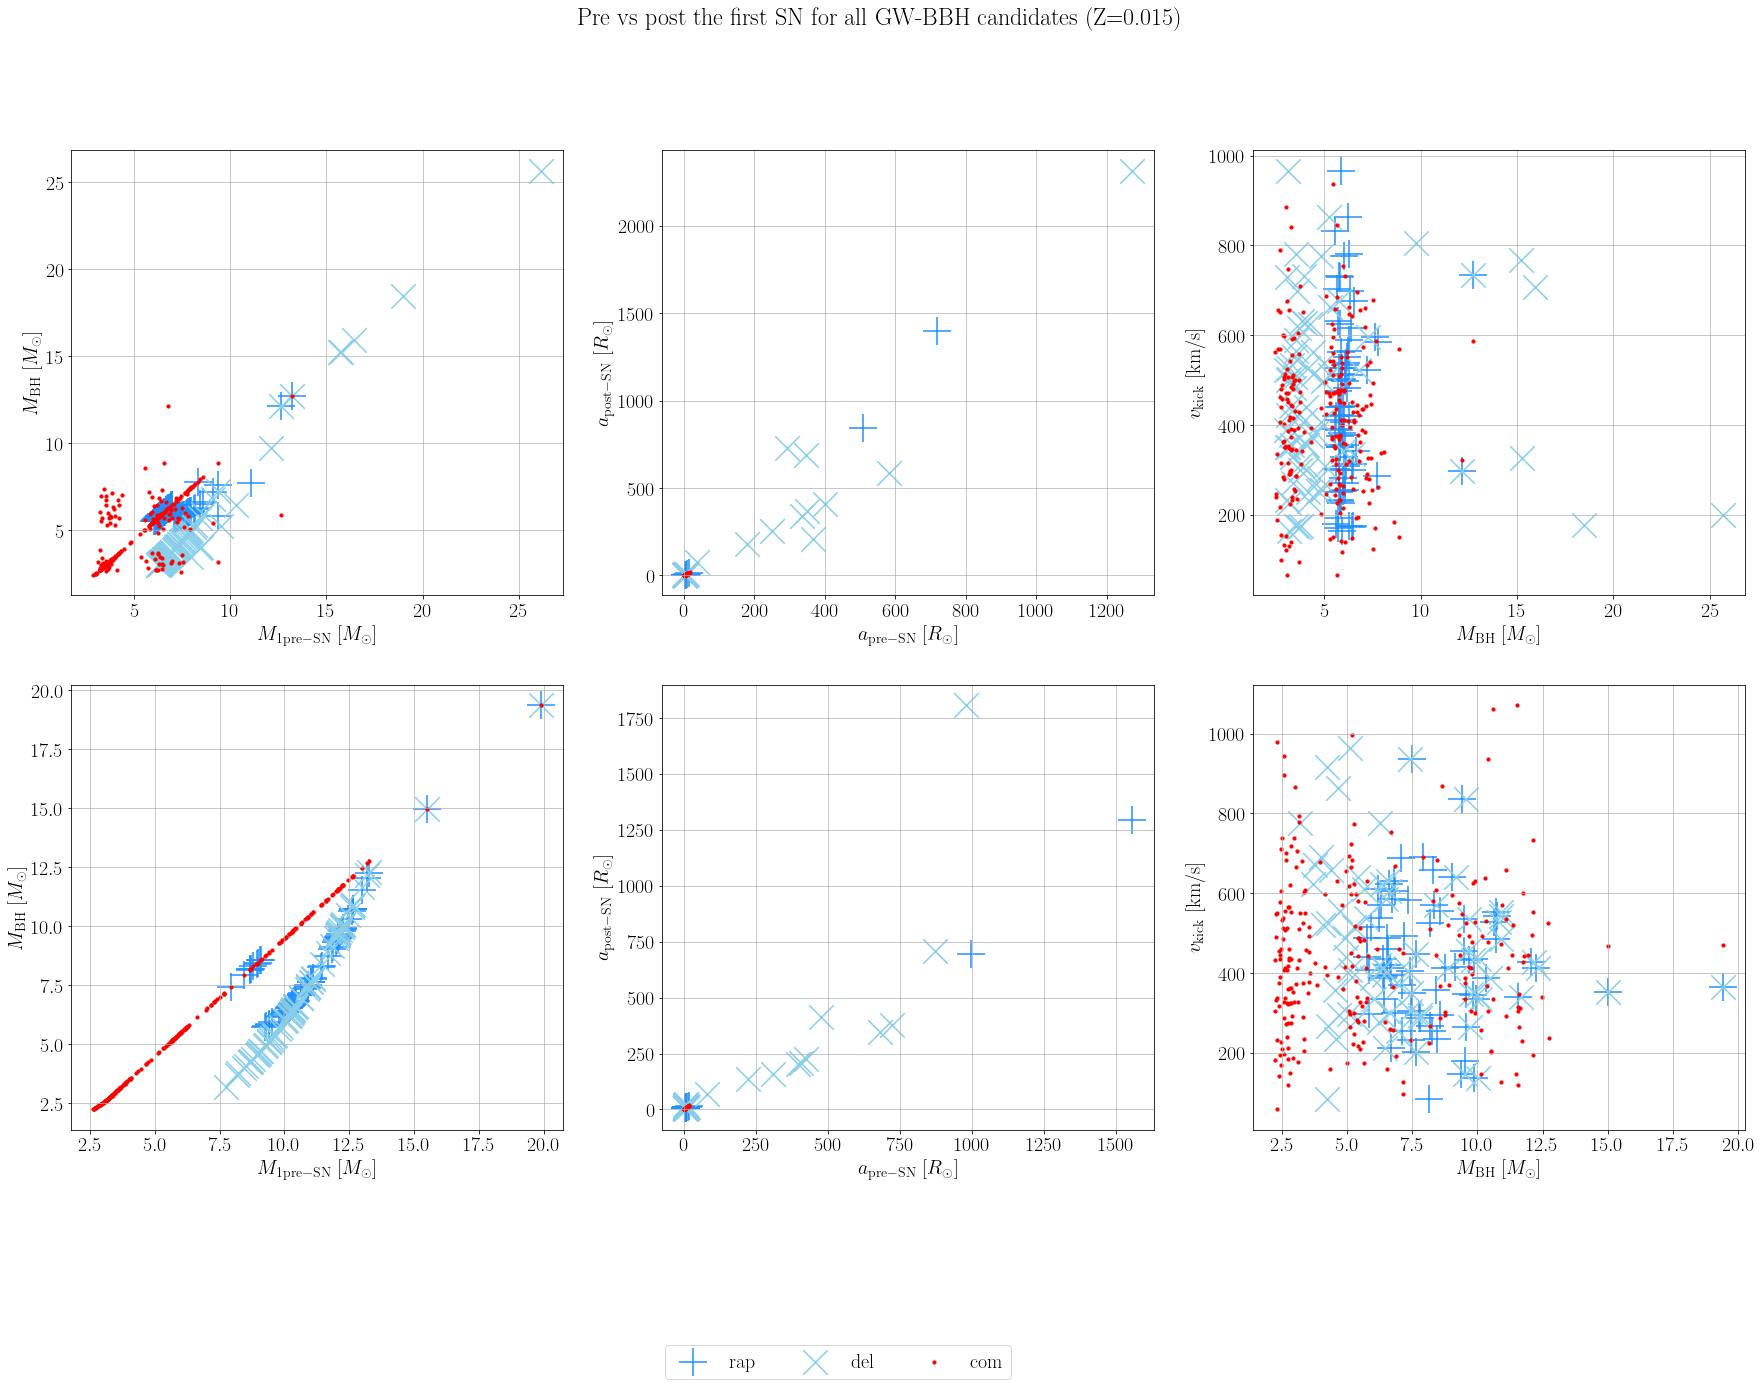

In [11]:
#### preliminary select subset of interest ###
df_name = f'{bintype}'
path_plot = f'./v_{version}/'
plottype = f'pre_post_SN_{bintype}_{kick_single}'

# physical costants
G4pi2 =  9953108.1      # G/(4 pi^2) in units of R_sun^3/(M_sun yr^2)



#####################
### prepare plot ####
#####################
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
fig.suptitle(f'Pre vs post the first SN for all GW-BBH candidates (Z=0.{Z})')

#Z_list = [f'{Z}',f'{Z}']
#SN_list = ['del','com']
#SN_list = commonSNs
cmaps = ['Reds','Greys','Blues','Greens']
xlabels = [r'$M_{1 \rm pre-SN} ~ [M_\odot]$',r'$a_{\rm pre-SN} ~ [R_\odot]$', r'$M_{\rm BH} ~ [M_\odot]$',
          r'$M_{1 \rm pre-SN} ~ [M_\odot]$',r'$a_{\rm pre-SN} ~ [R_\odot]$', r'$M_{\rm BH} ~ [M_\odot]$']
ylabels = [r'$M_{\rm BH} ~ [M_\odot]$',r'$a_{\rm post-SN} ~ [R_\odot]$', r'$v_{\rm kick}$ [km/s]',
          r'$M_{\rm BH} ~ [M_\odot]$',r'$a_{\rm post-SN} ~ [R_\odot]$', r'$v_{\rm kick}$ [km/s]']
#versions = ['3.0.0-Spindevel_RLO']

markers = ['+','x','o']
#leglabels = [f'{SNs[0]}',f'{SNs[1]}',f'{SNs[2]}']
sizes= [800,600,10]
scatter_colors = ['dodgerblue','skyblue','red']       



        
        
# read list of common candidate names for the fixed mass range between the desired SN models
path_kick = f'./v_{version}/Z{Z}_{kick_single}'




# # prepare colors for lines
# NUM_COLORS = len(commons)
# cm = plt.get_cmap('inferno_r')
# colors=[]
# for i in range(NUM_COLORS):
#     colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple



for SN,marker,sc_color,size in zip(SNs,markers,scatter_colors,sizes):
#     try:
#         names_read = pd.read_csv(f'{path_kick}/{mrange}_{SN}_{df_name}.txt',header=None)
#         names_read = names_read[0].to_list()
#         names = list(map(str,map(int,names_read))) # convert into list of strings
#     except pd.errors.EmptyDataError:
#         names = []
    
    ### set paths ###
    path = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick_single}'          # folder path identifier for a specific simulation run

    ############################################
    ########### extract SN infos  ##############
    ############################################
    path_log = f'{path}/{df_name}/run_scripts/sevn_output/logfile_0.dat'    
    log = pd.read_csv(f'{path_log}')

    df = LogfileExtractSN(path_log,nSN=0)  
    df2 = LogfileExtractSN(path_log,nSN=1)  
    # prepare values to scatter on x and y axis
    xs = [df['Mtot0'],df['ain'],  df['Mrem'],df2['Mtot1'],df2['ain'],  df2['Mrem']]
    ys = [df['Mrem'],df['aout'], df['vkick'],df2['Mrem'],df2['aout'], df2['vkick']]
    
    



    ############################################
    ########### plot  #########################
    ############################################
    
    for ax,x,y,xlabel,ylabel in zip (axs.flat,xs,ys,xlabels,ylabels):
        #if (ax == axs[0][0]) | (ax == axs[0][1]) | (ax == axs[0][2]):
        ax.scatter(x,y, marker=marker,c=sc_color,s=size,label=SN)
#             elif  (ax == axs[1][0]) | (ax == axs[1][1]) | (ax == axs[1][2]): 
#                 print(xlabel)
#                 ax.scatter(x2,y2, marker=marker,edgecolor='k',c=sc_color,s=size,label=SN)
#         if (SN == SN_list[0]):
#             for i,col in zip(range(0,len(commons)),colors):
#                 ax.plot([x.iloc[i],x.iloc[i]],[x.iloc[i],y.iloc[i]],color=col,lw=3,zorder=1)
#             if kick_single == 'unified':
#                 ax.scatter(x,x, marker='*',edgecolor='k',c='k',s=size,label='pre-SN',zorder=2)


        ax.grid(alpha=0.9)


        ax.set_xlabel(f'{xlabel}')
        ax.set_ylabel(f'{ylabel}') 

        
        axs[0][0].set_xlim(2.5,30)
        axs[0][0].set_ylim(2.5,30)
        axs[0][1].set_xlim(0.,.4000)
        axs[0][1].set_ylim(2.,20.)
        axs[0][2].set_xlim(3,10.)
        axs[0][2].set_ylim(0.,1200.)
        
        axs[1][0].set_xlim(3,14)
        axs[1][0].set_ylim(3,14)
        axs[1][1].set_xlim(2.,7.)
        axs[1][1].set_ylim(2.,20.)
        axs[1][2].set_xlim(3,10.)
        axs[1][2].set_ylim(0.,1200.)

        
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.48,0.02))   
#plt.tight_layout()
fig.subplots_adjust(bottom=0.2)

plt.show()
fig.savefig(f'{path_plot}Z{Z}_{plottype}.jpg')

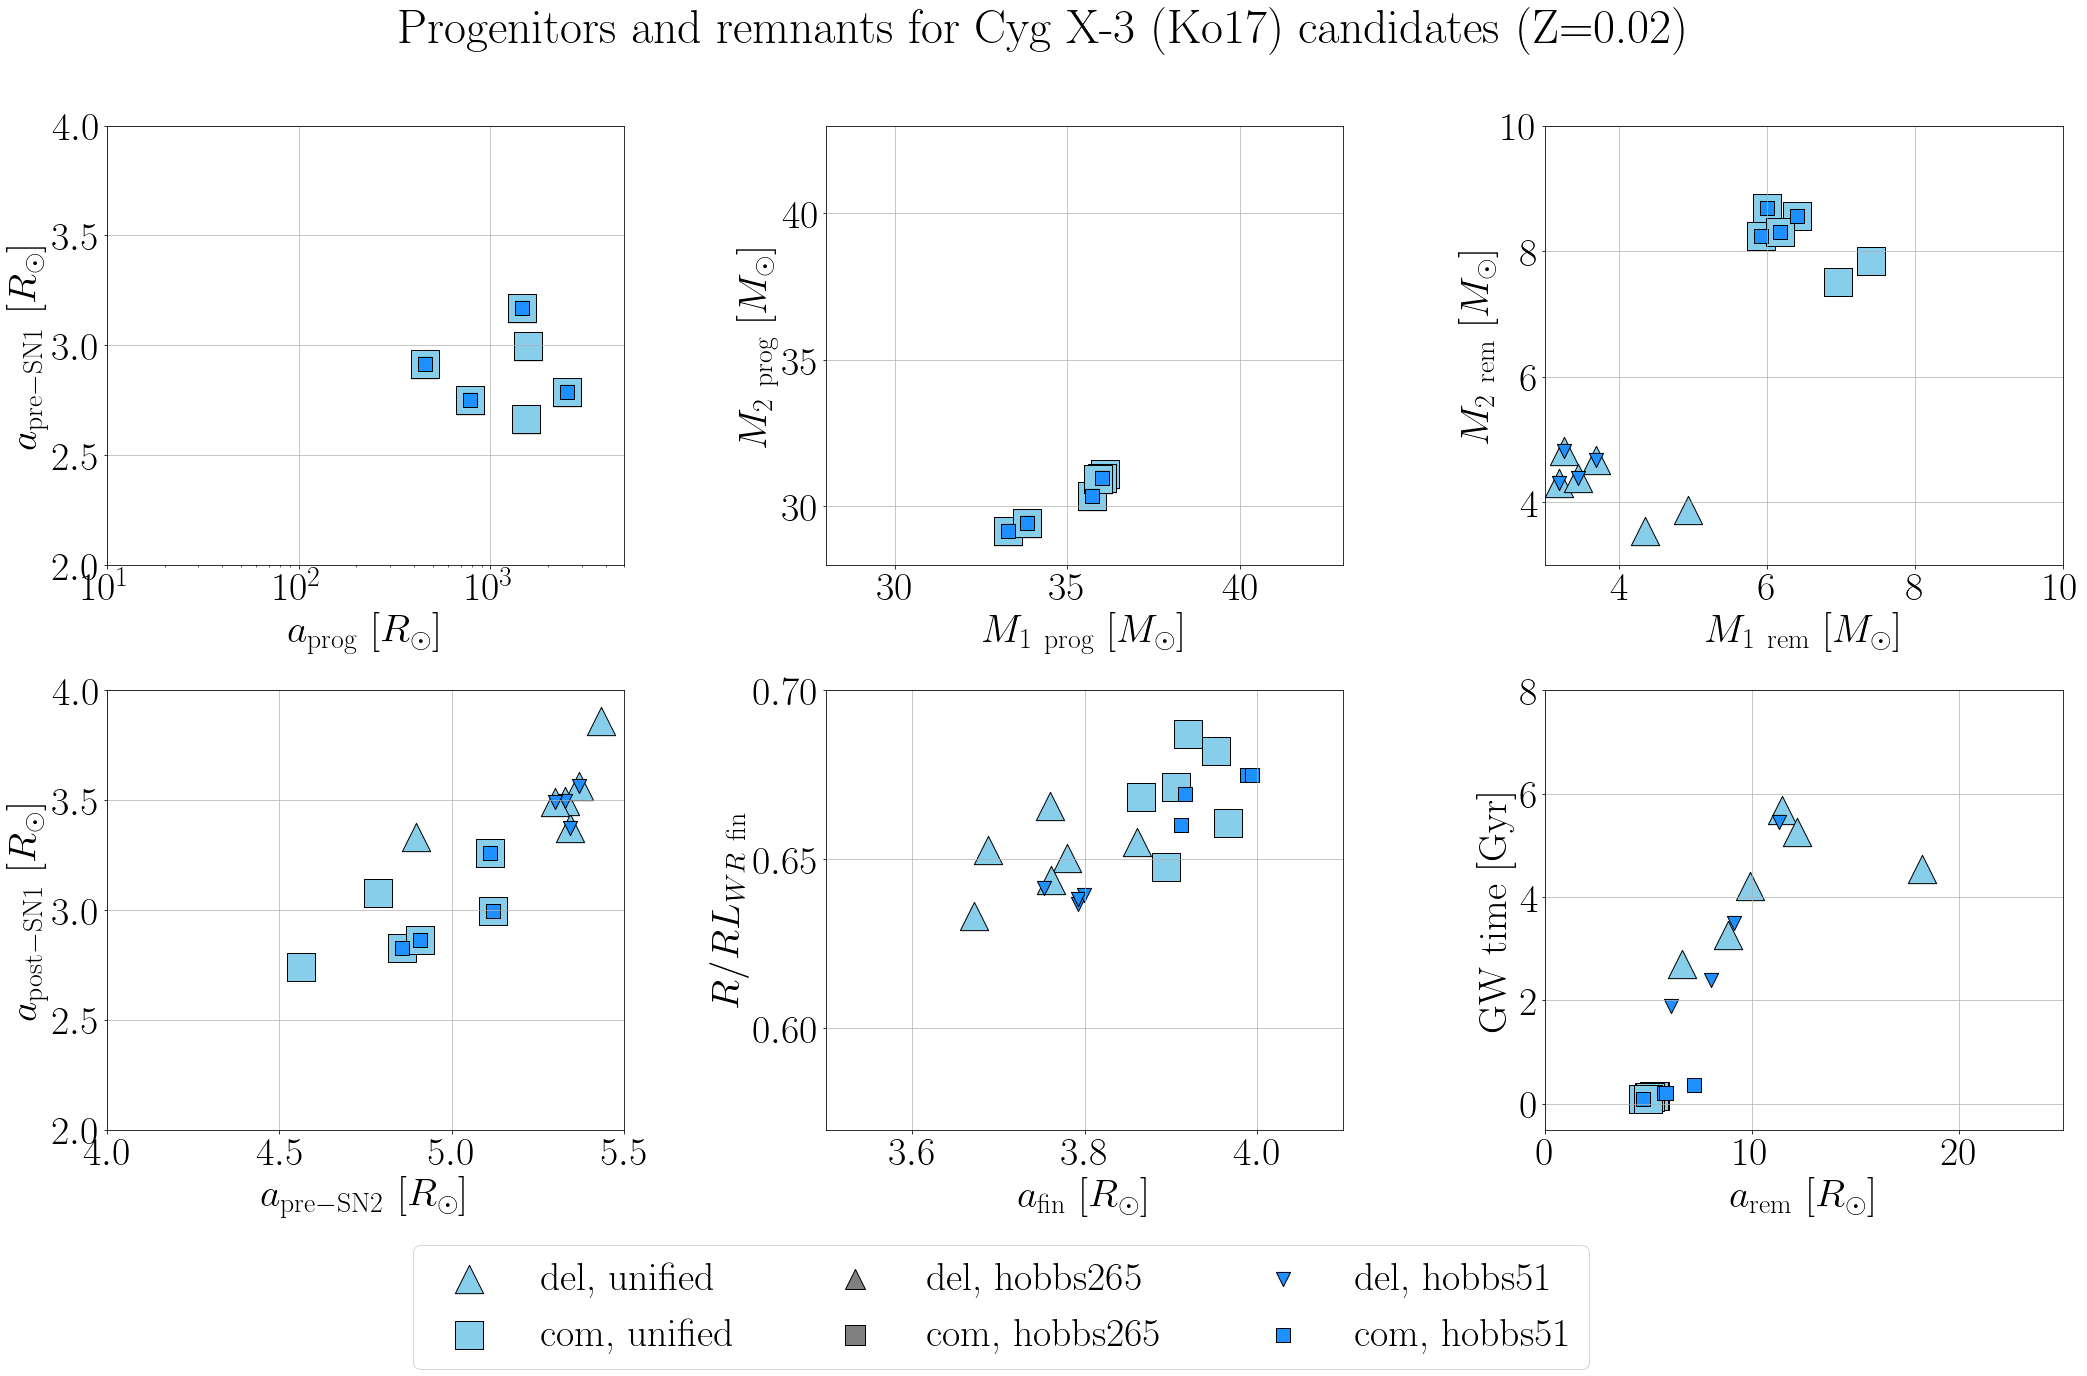

In [303]:
plottype = 'prog_rem'

#### preliminary select subset of interest ###
mrange = 'Ko17'
df_name = f'{bintype}_{obs}--{mrange}'
path_plot = f'./v_{version}/'

# physical costants
G4pi2 =  9953108.1      # G/(4 pi^2) in units of R_sun^3/(M_sun yr^2)



#####################
### prepare plot ####
#####################
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
fig.suptitle(f'Progenitors and remnants for {observed} ({mrange}) candidates (Z=0.{Z})')

Z_list = [f'{Z}',f'{Z}']
SN_list = ['del','com']
xlabels = [r'$a_{\rm prog} ~ [R_\odot]$',r'$M_{1 ~\rm prog} ~ [M_\odot]$',r'$M_{1 ~\rm rem} ~ [M_\odot]$', r'$a_{\rm pre-SN2} ~ [R_\odot]$',r'$a_{\rm fin} ~ [R_\odot]$', r'$a_{\rm rem} ~ [R_\odot]$']
ylabels = [r'$a_{\rm pre-SN1} ~ [R_\odot]$',r'$M_{2 ~\rm prog} ~ [M_\odot]$',r'$M_{2 ~\rm rem} ~ [M_\odot]$',r'$a_{\rm post-SN1} ~ [R_\odot]$', r'$R/RL_{WR ~\rm fin}$', r'GW time [Gyr]']

#versions = ['3.0.0-Spindevel_RLO']

for kick in kicks:
    if kick == 'unified':
        markers = ['^','s']
        c = 'skyblue'
        leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
        size=800
        scatter_colors = ['grey','dodgerblue']       
    elif kick == 'hobbs265':
        markers = ['^','s']
        c = 'grey'
        leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
        size = 400
        scatter_colors = ['pink','pink']
    elif kick == 'hobbs51':
        c = 'dodgerblue'
        markers = ['v','s']
        leglabels = [f'{commonSNs[0]}, {kick}',f'{commonSNs[1]}, {kick}']
        size = 200
 
        
    
    # read list of common candidate names for the fixed mass range between the desired SN models
    path_kick = f'./v_{version}/Z{Z}_{kick}'
    try:
        common_read = pd.read_csv(f'{path_kick}/common_{mrange}_{commonSNs[0]}_{commonSNs[1]}.txt',header=None)
        common_read = common_read[0].to_list()
        commons = list(map(str,map(int,common_read))) # convert into list of strings
    except pd.errors.EmptyDataError:
        commons = []

        
        
    # prepare colors for lines
    # so that each binary has a different color
    NUM_COLORS = len(commons)
    cm = plt.get_cmap('inferno_r')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
    
    for Z,SN,leglabel,marker,sc_color in zip(Z_list,commonSNs,leglabels,markers,scatter_colors):
        ### set paths ###
        path = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}'          # folder path identifier for a specific simulation run
        path_df = f'{path}/dataframes/'
        
        prog = pd.read_csv(f'{path_df}/progenitors/p_{df_name}.csv')
        rem = pd.read_csv(f'{path_df}/remnants/r_{df_name}.csv')
        fin = pd.read_csv(f'{path_df}/final_WRBH/f_{df_name}.csv')
        
        prog.name=prog.name.astype('str')
        rem.name=rem.name.astype('str')
        fin.name=fin.name.astype('str')
        prog.a=prog.a.astype('float')

        prog = prog.loc[prog['name'].isin(commons)].sort_values('name')
        rem = rem.loc[rem['name'].isin(commons)].sort_values('name')
        fin = fin.loc[fin['name'].isin(commons)].sort_values('name')

        
        ############################################
        ########### extract SN infos  ##############
        ############################################
        path_log = f'{path}/{df_name}/run_scripts/sevn_output/logfile_0.dat'    
        log = pd.read_csv(f'{path_log}')


        ### extract SN events from the logfile ###
        # logfile BSN lines have the following structure
        # B;name;ID;BSN;time;ID_0:M_tot0:M_He0:M_CO0:phase0:remtype0:ID_1:M_tot1:M_He1:M_CO1:phase1:remtype1:ain:ein:aout...........:eout:cos:vCM
        # where M_tot,M_He,M_CO are before the SN explosion
        exp = "\d+\.\d+[eE][+-]\d+"   # exponential
        regex_strBSN1=f'B;(\d+);\d+;BSN;(\d+.\d+);0:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+:(\d+.\d+):'
        regex_strBSN2=f'B;(\d+);\d+;BSN;(\d+.\d+);0:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+.\d+:(\d+.\d+):'
        # second SN
        regex_strBSN_2SN=f'B;(\d+);\d+;BSN;(\d+.\d+);1:({exp}):{exp}:{exp}:\d+:\d+:\d+:({exp}):{exp}:{exp}:\d+:\d+:(\d+.\d+):\d+.\d+:(\d+.\d+):'
        #
        # logfile BSN lines have the following structure
        # S;name;ID;SN;time;M_tot:M_He:M_CO:M_rem:rem_type:vkick
        # where M_tot,M_He,M_CO are before the SN explosion
        regex_strSN='S;(\d+);0;SN;(\d+.\d+);(\d+.\d+):\d+.\d+:\d+.\d+:(\d+.\d+):\d+:(\d+.\d+):'

        with open(path_log,"r") as f:
            BSN1_mask = re.findall(regex_strBSN1,f.read())             #Find al the BSN occurence
        with open(path_log,"r") as f:
            BSN2_mask = re.findall(regex_strBSN2,f.read())             #Find al the BSN occurence
        with open(path_log,"r") as f:
            BSN2_2SN_mask = re.findall(regex_strBSN_2SN,f.read())      #Find al the BSN occurence for second SN
        with open(path_log,"r") as f:
            SN_mask = re.findall(regex_strSN,f.read())             #Find al the SN occurence

        # convert into dataframes
        colBSN_names = ['name','time','Mtot0','Mtot1','ain','aout']
        BSN1 = pd.DataFrame(BSN1_mask, columns=colBSN_names)   # convert into pandas dataframe
        BSN2 = pd.DataFrame(BSN2_mask, columns=colBSN_names)   # convert into pandas dataframe
        BSN = pd.concat([BSN1,BSN2])
        
        colBSN_2SN_names = ['name','time','Mtot1','Mtot0','ain','aout']
        B2SN = pd.DataFrame(BSN2_2SN_mask, columns=colBSN_2SN_names)   # convert into pandas dataframe
        

        colSN_names = ['name','time','Mtot','Mrem','vkick']
        SNdf = pd.DataFrame(SN_mask, columns=colSN_names)   # convert into pandas dataframe

        # specify types of columns
        BSN.name=BSN.name.astype('str')
        BSN.Mtot0=BSN.Mtot0.astype('float')
        BSN.Mtot1=BSN.Mtot1.astype('float')
        BSN.ain=BSN.ain.astype('float')
        BSN.aout=BSN.aout.astype('float')
        SNdf.name=SNdf.name.astype('str')
        SNdf.Mrem=SNdf.Mrem.astype('float')
        SNdf.vkick=SNdf.vkick.astype(float)
        
        B2SN.name=B2SN.name.astype('str')
        B2SN.Mtot0=B2SN.Mtot0.astype('float')
        B2SN.Mtot1=B2SN.Mtot1.astype('float')
        B2SN.ain=B2SN.ain.astype('float')
        B2SN.aout=B2SN.aout.astype('float')


        #select only rows of interest
        BSN = BSN.loc[BSN['name'].isin(commons)].sort_values('name')
        SNdf = SNdf.loc[SNdf['name'].isin(commons)].sort_values('name')
        df = pd.concat([BSN,SNdf[['Mrem','vkick']]],axis=1).sort_values('name')
        
        B2SN = B2SN.loc[B2SN['name'].isin(commons)].sort_values('name')


        # prepare values to scatter on x and y axis
        xs = [prog['a'],prog['Mass_0'],rem['Mass_0'], B2SN['ain'], fin['Semimajor'],rem['Semimajor']]
        ys = [df['ain'],prog['Mass_1'],rem['Mass_1'],  df['aout'], fin['RL1_fill'],rem['GWtime']/1000.]
        


        ############################################
        ########### plot  #########################
        ############################################

        for ax,x,y,xlabel,ylabel in zip (axs.flat,xs,ys,xlabels,ylabels):
            ax.scatter(x,y, marker=marker,edgecolor='k',c=c,s=size,label=leglabel)


            ax.grid(alpha=0.9)


            ax.set_xlabel(f'{xlabel}')
            ax.set_ylabel(f'{ylabel}') 
        axs[0][0].set_xlim(10,5000)
        axs[0][0].set_ylim(2.,4.)
        axs[0][1].set_xlim(28,43)
        axs[0][1].set_ylim(28,43)
        axs[0][2].set_xlim(3,10)
        axs[0][2].set_ylim(3,10)
        axs[1][0].set_xlim(4.,5.5)
        axs[1][0].set_ylim(2.,4.)
        axs[1][1].set_xlim(3.5,4.1)
        axs[1][1].set_ylim(0.57,0.7)
        axs[1][2].set_xlim(0.,25.)
        axs[1][2].set_ylim(-0.5,8)
        
        axs[0][0].set_xscale('log')

        
        

        
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.48,0.02))   
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)

plt.show()
fig.savefig(f'{path_plot}Z{Z}_{plottype}_{mrange}.jpg')